<a href="https://colab.research.google.com/github/drOluOla/Lloyds_DA_AI_Scientist_Take_Home/blob/main/Lloyds_Take_Home_Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
Actionable insights into customer savings behavior are crucial for driving business growth and improving organisation's relationship with customer. The analysis in this report uses different Statistical and Machine Learning models to identify key patterns in historic saving behaviours for predicting future amounts that customers might save up. More importantly, the analysis identified multiple sensitive variables including protected characteristics (age, gender, ethnicity) and socioeconomic factors (income, credit score, savings). The most concerning pattern is age-based unfairness. A demo prototype showcasing how generative AI can be applied to produce personalized counterfactual savings analysis and actionable financial recommendations is also included in the report.

# **Methods**

Given that the dataset contained historic saving behaviour of customers that can be used for predicting future saving amounts. The prediction objective can be neatly mapped onto a standard regression task that requires multiple processing step. To manage my time, I broke the tasks into tickets and tracked progress iteratively on a Kanban board (image below), with subtasks similar to one detailed in the [GitHub project link](https://github.com/users/drOluOla/projects/2).[GitHub project link](https://github.com/users/drOluOla/projects/2).

![](https://drive.google.com/uc?export=view&id=121BTN4Nhs75LCoV9K3zbkLwmYvOqDCNO)

## **Libraries and Tools Used:**
-   **Stats Model**
      - For Statistical Modelling
-   **Scikit learn**
      - For Machine Learning Modelling
-   **Seaborn and Matplotlib **
      - For visualisation
-   **Fairlearn**
      - Fairness analysis
-   **Computer Assisted Coding (Gemini)**
      - For code completion
      - For code formatting
      - For code documentation

# **Implementation**

### **Package Installation**

In [16]:
%pip install openai-agents
%pip install fairlearn

In [17]:
# Standard library
import argparse
import json
import logging
import os
import warnings
from math import isfinite
from pathlib import Path
from typing import Dict, Optional, Union, Tuple, List, Any

# Google Colab
from google.colab import drive, userdata

# Third-party core
from dotenv import load_dotenv
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific/Statistical
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson

# Machine Learning - Sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Machine Learning - Other
import xgboost as xgb
from fairlearn.metrics import MetricFrame

# Custom modules
from agents import Agent, Runner
from openai import OpenAI

### **Global Variables**

In [18]:
# Warning configuration
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to the files in Google Drive
data_path = "/content/drive/My Drive/Job_2025/Lloyds/dataset/savings_customers_data_v1 8.xlsx"
dictionary_path = "/content/drive/My Drive/Job_2025/Lloyds/dataset/data_dictionary_v1 8.xlsx"

data_exists = os.path.exists(data_path)
dictionary_exists = os.path.exists(dictionary_path)

# Verify paths to data and dictionary exist
if data_exists and dictionary_exists:
    print("Both data and dictionary files found!")
else:
    if not data_exists:
        print(f"Error: Data file not found at {data_path}")
    if not dictionary_exists:
        print(f"Error: Dictionary file not found at {dictionary_path}")
    print("Please ensure both data and dictionary files are in the correct Google Drive location and the paths are accurate.")


# Verify API Key has been correctly setup for Question 6
openai_api_key = userdata.get('OPENAI_API_KEY')

instructions = "You are a helpful econometric assistant. Reply in a 7-word clear and simple sentence"
agent = Agent(name="Assistant", instructions=instructions)

if openai_api_key:
    os.environ["OPENAI_API_KEY"] = openai_api_key
    result = await Runner.run(agent, "How can Lloyds Bank ensure fairness and reduce bias using saving habits?")
    print(result.final_output)
else:
    print("Please set the OPENAI_API_KEY environment variable in Colab Secrets.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Both data and dictionary files found!
Analyze data, adjust models, monitor outcomes regularly.


### **Utilities**

In [19]:
class Utilities:
    """
    A class for utility functions, including data visualization.
    """
    def __init__(self, data: pd.DataFrame, target_variable: str):
        self.data = data
        self.target_variable = target_variable

    ####################################################
    # Initial Exploration Helpers
    ####################################################
    def plot_target_distribution(self, output_dir: Path) -> None:
        """
        Plots the distribution and box plot of the target variable.
        """
        if self.target_variable in self.data.columns:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].hist(self.data[self.target_variable], bins=30, alpha=0.7)
            axes[0].set_title('Target Distribution')
            axes[1].boxplot(self.data[self.target_variable])
            axes[1].set_title('Target Box Plot')
            plt.tight_layout()
            plt.show()
            plt.close()
        else:
            print(f"Target variable '{self.target_variable}' not found in the data.")

    def plot_correlation_matrix(self, output_dir: Path) -> None:
        """
        Plots the correlation matrix of numeric variables.
        """
        numeric_data = self.data.select_dtypes(include=[np.number])
        correlation_matrix = numeric_data.corr()
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()
        plt.close()

    def plot_categorical_vs_target(self, output_dir: Path, num_cols_to_plot: int = 3) -> None:
        """
        Plots box plots of the target variable against categorical variables.
        """
        categorical_columns = self.data.select_dtypes(include=['object', 'category']).columns

        # Exclude 'credit_score' from categorical plotting because mixed dtypes
        categorical_columns = [col for col in categorical_columns if col != 'credit_score']

        for col in categorical_columns[:num_cols_to_plot]:
            if self.target_variable in self.data.columns:
                plt.figure(figsize=(8, 5))
                sns.boxplot(data=self.data, x=col, y=self.target_variable)
                plt.title(f'{self.target_variable} by {col}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                plt.close()
            else:
                print(f"Target variable '{self.target_variable}' not found in the data.")

    def plot_all_distributions(self, output_dir: Path, num_categorical_cols: int = 3) -> None:
        """
        Generates a composite figure with target distribution, correlation matrix,
        selected categorical vs. target variable plots, and a pair plot of numeric data.
        """
        # Identify original numeric columns
        original_numeric_data = self.data.select_dtypes(include=[np.number])

        # Exclude engineered features and specified columns for pair plot
        engineered_features = ['savings_rate', 'age_group', 'discretionary_income', 'is_high_saver']
        cols_to_exclude = engineered_features + ['cust_unique_id', 'childcare_spend', 'gambling_spend', '']
        pair_plot_data = original_numeric_data.drop(columns=[col for col in cols_to_exclude if col in original_numeric_data.columns], errors='ignore')
        num_pair_plot_cols = pair_plot_data.shape[1]

        # Use all numeric data for correlation matrix
        numeric_data_for_corr = original_numeric_data.copy()


        # Determine the number of rows needed
        num_categorical_rows = (num_categorical_cols + 1) // 2
        num_rows = 2 + num_categorical_rows + (1 if num_pair_plot_cols >= 2 else 0) # Add row for pairplot if enough numeric cols

        fig = plt.figure(figsize=(12, 4 * num_rows))
        gs = fig.add_gridspec(num_rows, 2) # Always 2 columns

        # Target Distribution
        if self.target_variable in self.data.columns:
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.hist(self.data[self.target_variable], bins=30, alpha=0.7)
            ax1.set_title('Target Distribution')

            ax2 = fig.add_subplot(gs[0, 1])
            ax2.boxplot(self.data[self.target_variable])
            ax2.set_title('Target Box Plot')
        else:
             print(f"Target variable '{self.target_variable}' not found in the data.")


        # Correlation Matrix (using all numeric data)
        correlation_matrix = numeric_data_for_corr.corr()
        ax3 = fig.add_subplot(gs[1, :]) # Span across both columns
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, ax=ax3) # Changed annot to False for cleaner look in composite
        ax3.set_title('Correlation Matrix')

        # Categorical vs. Target Plots
        categorical_columns = self.data.select_dtypes(include=['object', 'category']).columns
        categorical_columns = [col for col in categorical_columns if col != 'credit_score']
        for i, col in enumerate(categorical_columns[:num_categorical_cols]):
            row_index = 2 + i // 2
            col_index = i % 2
            if self.target_variable in self.data.columns:
                ax = fig.add_subplot(gs[row_index, col_index])
                sns.boxplot(data=self.data, x=col, y=self.target_variable, ax=ax)
                ax.set_title(f'{self.target_variable} by {col}')
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
            else:
                print(f"Target variable '{self.target_variable}' not found in the data.")

        plt.tight_layout()
        plt.show()
        plt.close()

        # Pair Plot (using filtered numeric data) - separate figure
        if num_pair_plot_cols >= 2:
             pair_plot_fig = sns.pairplot(pair_plot_data)
             pair_plot_fig.fig.suptitle('Pair Plot of Original Numeric Features', y=1.02)
             plt.show()
             plt.close()


    ####################################################
    # Data Cleaning and Processing Helpers
    ####################################################
    def show_data_types(self) -> None:
        """Displays the data types of each column."""
        print("\n" + "="*50)
        print("DATA TYPES")
        print("="*50)
        display(self.data.dtypes)

    def show_missing_values_summary(self) -> None:
        """Display comprehensive missing values analysis."""
        missing_data_count = self.data.isnull().sum()
        missing_data_percentage = (missing_data_count / len(self.data)) * 100
        missing_data_df = pd.DataFrame({
            'Count': missing_data_count,
            'Percentage': missing_data_percentage
        })
        print("\nMissing Values:")
        display(missing_data_df[missing_data_df['Count'] > 0])

    def show_target_variable_analysis(self) -> None:
        """Comprehensive target variable analysis."""
        if self.target_variable not in self.data.columns:
            print(f"Target variable '{self.target_variable}' not found in data.")
            return

        target = self.data[self.target_variable]
        print(f"\n{'='*50}")
        print(f"TARGET VARIABLE ANALYSIS: {self.target_variable}")
        print(f"{'='*50}")
        print(f"Count: {len(target)}")
        print(f"Mean: ${target.mean():,.2f}")
        print(f"Median: ${target.median():,.2f}")
        print(f"Std: ${target.std():,.2f}")
        print(f"Min: ${target.min():,.2f}")
        print(f"Max: ${target.max():,.2f}")

        # Zero-inflation check
        zero_count = (target == 0).sum()
        zero_pct = (zero_count / len(target)) * 100
        print(f"\nZero values: {zero_count} ({zero_pct:.2f}%)")
        print(f"Positive values: {(target > 0).sum()} ({100-zero_pct:.2f}%)")

        # Stats among savers only
        positive_count = (target > 0).sum()
        if positive_count > 0:
            savers = target[target > 0]
            print(f"\nAmong Savers Only (n={positive_count}):")
            print(f"  Mean: ${savers.mean():,.2f}")
            print(f"  Median: ${savers.median():,.2f}")
            print(f"  Std Dev: ${savers.std():,.2f}")
            print(f"  Min: ${savers.min():,.2f}")
            print(f"  Max: ${savers.max():,.2f}")

    def check_zero_variance_columns(self) -> None:
        """Check for constant/zero-variance columns."""
        print("\nChecking for zero-variance columns...")
        found_constant = False
        for col in self.data.select_dtypes(include=[np.number]).columns:
            if self.data[col].nunique() == 1:
                print(f"  ⚠️  {col}: constant value ({self.data[col].iloc[0]})")
                found_constant = True
        if not found_constant:
            print("  ✓ No zero-variance columns found")

    def show_basic_statistics(self) -> None:
        """Display basic statistical summary."""
        print("\nBasic Statistics:")
        display(self.data.describe())

    ####################################################
    # Stats Models Helpers
    ####################################################
    @staticmethod
    def prepare_model_data(data: pd.DataFrame, target_variable: str, max_categories: int = 50):
        """Prepare data for modeling by handling categoricals and cleaning."""
        model_data = data.copy()

        # Remove ID columns
        id_cols = [col for col in model_data.columns
                   if 'id' in col.lower() or 'unique' in col.lower()]
        if id_cols:
            model_data = model_data.drop(columns=id_cols, errors='ignore')

        # Convert string columns to numeric where possible
        for col in model_data.columns:
            if col != target_variable and model_data[col].dtype == 'object':
                try:
                    converted = pd.to_numeric(model_data[col], errors='coerce')
                    if converted.notna().sum() / len(converted) > 0.8:
                        model_data[col] = converted
                except:
                    pass

        # Handle categorical variables
        categorical_cols = model_data.select_dtypes(include=['object', 'category']).columns
        categorical_cols = [col for col in categorical_cols if col != target_variable]

        for col in categorical_cols:
            n_unique = model_data[col].nunique()
            if n_unique > max_categories:
                top_cats = model_data[col].value_counts().nlargest(max_categories).index
                model_data[col] = model_data[col].where(
                    model_data[col].isin(top_cats), other='_other_'
                )
            dummies = pd.get_dummies(model_data[col], prefix=col, drop_first=True, dtype=int)
            model_data = pd.concat([model_data, dummies], axis=1)
            model_data.drop(col, axis=1, inplace=True)

        # Split features and target
        y = model_data[target_variable]
        X = model_data.drop(target_variable, axis=1).select_dtypes(include=[np.number])

        # Clean data
        combined = pd.concat([X, y], axis=1)
        combined = combined.replace([np.inf, -np.inf], np.nan).dropna()

        if len(combined) == 0:
            return None, None, None, None

        X_clean = combined.iloc[:, :-1]
        y_clean = combined.iloc[:, -1]
        is_saver = (y_clean > 0).astype(int)

        return X_clean, y_clean, is_saver, X

    @staticmethod
    def select_features(X: pd.DataFrame, y: pd.Series, method: str = 'mutual_info',
                       max_features: int = 30, task: str = 'regression',
                       filter_high_correlation: bool = True, correlation_threshold: float = 0.70):
        """
        Generic feature selection for both classification and regression tasks.
        """
        # Filter high correlations if requested
        if filter_high_correlation:
            correlations = X.corrwith(y).abs()
            high_corr_features = correlations[correlations > correlation_threshold].index.tolist()
            if high_corr_features:
                X_filtered = X.drop(columns=high_corr_features)
            else:
                X_filtered = X.copy()
        else:
            X_filtered = X.copy()

        if X_filtered.shape[1] == 0:
            return sm.add_constant(pd.DataFrame()), []

        # Select features based on method and task
        if task == 'classification':
            if method == 'mutual_info':
                mi_scores = mutual_info_classif(X_filtered, y, random_state=42)
                feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
            elif method == 'f_test':
                selector = SelectKBest(score_func=f_classif, k='all')
                selector.fit(X_filtered, y)
                feature_scores = pd.Series(selector.scores_, index=X_filtered.columns)
            elif method == 'correlation':
                feature_scores = X_filtered.corrwith(y).abs()
            else:
                mi_scores = mutual_info_classif(X_filtered, y, random_state=42)
                feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
        else:  # regression
            if method == 'mutual_info':
                mi_scores = mutual_info_regression(X_filtered, y, random_state=42)
                feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
            elif method == 'f_test':
                selector = SelectKBest(score_func=f_regression, k='all')
                selector.fit(X_filtered, y)
                feature_scores = pd.Series(selector.scores_, index=X_filtered.columns)
            elif method == 'lasso':
                lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
                lasso.fit(X_filtered, y)
                feature_scores = pd.Series(np.abs(lasso.coef_), index=X_filtered.columns)
            elif method == 'correlation':
                feature_scores = X_filtered.corrwith(y).abs()
            else:
                mi_scores = mutual_info_regression(X_filtered, y, random_state=42)
                feature_scores = pd.Series(mi_scores, index=X_filtered.columns)

        top_features = feature_scores.nlargest(max_features).index.tolist()
        X_selected = X_filtered[top_features]

        return sm.add_constant(X_selected), top_features

    @staticmethod
    def calculate_regression_metrics(y_true: np.ndarray, y_pred: np.ndarray):
        """Calculate common regression metrics."""
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        baseline_pred = np.full(len(y_true), y_true.mean())
        baseline_rmse = np.sqrt(mean_squared_error(y_true, baseline_pred))
        improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100

        return {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'baseline_rmse': baseline_rmse,
            'improvement_pct': improvement
        }

    @staticmethod
    def plot_diagnostics(y_clean, results, output_dir: Path):
        """Generate diagnostic plots for model evaluation."""
        output_dir.mkdir(exist_ok=True)

        try:
            fig, axes = plt.subplots(3, 2, figsize=(14, 15))
            fig.suptitle('Model Diagnostics', fontsize=16, fontweight='bold')

            # Two-Part: Actual vs Predicted
            if 'final_predictions' in results:
                ax = axes[0, 0]
                ax.scatter(y_clean, results['final_predictions'],
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                max_val = max(y_clean.max(), results['final_predictions'].max())
                ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
                ax.set_xlabel('Actual Savings (£)')
                ax.set_ylabel('Predicted Savings (£)')
                ax.set_title('Two-Part Model: Actual vs Predicted')
                ax.legend()
                ax.grid(True, alpha=0.3)

            # Two-Part: Residual Plot
            if 'final_predictions' in results:
                ax = axes[0, 1]
                residuals = y_clean - results['final_predictions']
                ax.scatter(results['final_predictions'], residuals,
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                ax.axhline(y=0, color='r', linestyle='--', lw=2)
                ax.set_xlabel('Predicted Savings (£)')
                ax.set_ylabel('Residuals (£)')
                ax.set_title('Two-Part Model: Residual Plot')
                ax.grid(True, alpha=0.3)

            # Distribution Comparison
            ax = axes[1, 0]
            ax.hist(y_clean, bins=50, alpha=0.6, label='Actual', edgecolor='black')
            if 'final_predictions' in results:
                ax.hist(results['final_predictions'], bins=50, alpha=0.6,
                       label='Two-Part', edgecolor='black')
            if 'ols_only_predictions' in results:
                ax.hist(results['ols_only_predictions'], bins=50, alpha=0.6,
                       label='OLS-Only', edgecolor='black')
            ax.set_xlabel('Savings (£)')
            ax.set_ylabel('Frequency')
            ax.set_title('Distribution Comparison')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')

            # R² Comparison
            if 'comparison_table' in results:
                ax = axes[1, 1]
                comp_df = results['comparison_table']
                models = comp_df['Model'].tolist()
                r2_values = comp_df['R²'].tolist()

                bars = ax.barh(models, r2_values, color=['lightgray', 'skyblue', 'lightgreen'])
                ax.set_xlabel('R² Score')
                ax.set_title('Model Performance (R²)')
                ax.grid(True, alpha=0.3, axis='x')

                for i, (bar, val) in enumerate(zip(bars, r2_values)):
                    ax.text(val + 0.01, i, f'{val:.4f}', va='center')

            # OLS-Only diagnostics
            if 'ols_only_predictions' in results and 'ols_only_model' in results:
                ols_only_pred = results['ols_only_predictions']
                ols_only_residuals = y_clean - ols_only_pred

                ax = axes[2, 0]
                ax.scatter(ols_only_pred, ols_only_residuals,
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                ax.axhline(y=0, color='r', linestyle='--', lw=2)
                ax.set_xlabel('Fitted Values (£)')
                ax.set_ylabel('Residuals (£)')
                ax.set_title('OLS-Only: Residuals vs Fitted')
                ax.grid(True, alpha=0.3)

                ax = axes[2, 1]
                standardized_residuals = ols_only_residuals / ols_only_residuals.std()
                stats.probplot(standardized_residuals, dist="norm", plot=ax)
                ax.set_title('OLS-Only: Q-Q Plot')
                ax.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()
            plt.close()

        except Exception as e:
            print(f"\n⚠️ Could not generate plots: {e}")

    ####################################################
    # ML Models Helpers
    ####################################################
    @staticmethod
    def remove_id_columns(df: pd.DataFrame) -> pd.DataFrame:
        """Remove ID and unique identifier columns from dataframe."""
        id_cols = [col for col in df.columns
                   if 'id' in col.lower() or 'unique' in col.lower()]
        if id_cols:
            df = df.drop(columns=id_cols, errors='ignore')
        return df

    @staticmethod
    def convert_numeric_strings(df: pd.DataFrame, target_variable: str, threshold: float = 0.8) -> pd.DataFrame:
        """Convert string columns to numeric if >threshold% of values are numeric."""
        for col in df.columns:
            if col != target_variable and df[col].dtype == 'object':
                try:
                    converted = pd.to_numeric(df[col], errors='coerce')
                    if converted.notna().sum() / len(converted) > threshold:
                        df[col] = converted
                except:
                    pass
        return df

    @staticmethod
    def encode_categorical_features(df: pd.DataFrame, target_variable: str, max_categories: int = 50) -> pd.DataFrame:
        """One-hot encode categorical features with category limiting."""
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        categorical_cols = [col for col in categorical_cols if col != target_variable]

        for col in categorical_cols:
            n_unique = df[col].nunique()
            if n_unique > max_categories:
                top_cats = df[col].value_counts().nlargest(max_categories).index
                df[col] = df[col].where(df[col].isin(top_cats), other='_other_'
                )
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True, dtype=int)
            df = pd.concat([df, dummies], axis=1)
            df.drop(col, axis=1, inplace=True)

        return df

    @staticmethod
    def clean_infinite_and_nan(X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """Remove infinite values and NaN from features and target."""
        combined = pd.concat([X, y], axis=1)
        combined = combined.replace([np.inf, -np.inf], np.nan).dropna()

        if len(combined) == 0:
            return pd.DataFrame(), pd.Series()

        X_clean = combined.iloc[:, :-1]
        y_clean = combined.iloc[:, -1]
        X_clean = X_clean.loc[y_clean.index]

        return X_clean, y_clean

    @staticmethod
    def stratified_train_test_split(X: pd.DataFrame, y: pd.Series,
                                   test_size: float = 0.2,
                                   random_state: int = 42) -> Tuple:
        """Perform stratified train-test split with fallback for edge cases."""
        try:
            if y.nunique() > 1:
                y_quantiles = pd.qcut(y, q=10, labels=False, duplicates='drop')
                return train_test_split(X, y, test_size=test_size,
                                      random_state=random_state,
                                      stratify=y_quantiles)
            else:
                print("Warning: Target variable has only one unique value. Splitting without stratification.")
                return train_test_split(X, y, test_size=test_size, random_state=random_state)
        except Exception as e:
            print(f"Warning: Could not stratify on y quantiles ({e}). Splitting without stratification.")
            return train_test_split(X, y, test_size=test_size, random_state=42)

    @staticmethod
    def save_dataframe(df: pd.DataFrame, filename: str, output_dir: str = "analysis_outputs") -> None:
        """Save dataframe to CSV in specified directory."""
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        filepath = output_path / filename
        df.to_csv(filepath, index=False)
        print(f"\n💾 Saved: {filepath}")

    ####################################################
    # Ethic Analysis Helpers
    ####################################################

    @staticmethod
    def identify_sensitive_variables(df: pd.DataFrame, data_dictionary_path: Optional[str] = None) -> Dict:
        """Identify sensitive variables from data dictionary and columns."""
        sensitive = {
            'protected_characteristics': [],
            'proxy_variables': [],
            'socioeconomic_variables': [],
            'other_sensitive': []
        }

        # Load data dictionary if available
        if data_dictionary_path:
            data_dict_path = Path(data_dictionary_path)
            if data_dict_path.exists():
                try:
                    dd = pd.read_excel(data_dict_path)
                    var_col = dd.columns[0]
                    desc_col = dd.columns[1] if len(dd.columns) > 1 else None

                    if desc_col is not None:
                        for _, row in dd.iterrows():
                            var = str(row[var_col]).strip()
                            desc = str(row[desc_col]).lower()

                            if any(k in var.lower() or k in desc for k in ['gender', 'ethnicity', 'age', 'race', 'sex']):
                                if var in df.columns and var not in sensitive['protected_characteristics']:
                                    sensitive['protected_characteristics'].append(var)
                            elif any(k in var.lower() or k in desc for k in ['location', 'region', 'zip', 'postcode', 'address']):
                                if var in df.columns and var not in sensitive['proxy_variables']:
                                    sensitive['proxy_variables'].append(var)
                            elif any(k in var.lower() or k in desc for k in ['income', 'salary', 'wealth', 'savings', 'credit', 'debt']):
                                if var in df.columns and var not in sensitive['socioeconomic_variables']:
                                    sensitive['socioeconomic_variables'].append(var)
                            elif any(k in var.lower() or k in desc for k in ['health', 'medical', 'disability', 'religion', 'political']):
                                if var in df.columns and var not in sensitive['other_sensitive']:
                                    sensitive['other_sensitive'].append(var)
                except Exception as e:
                    warnings.warn(f"Error loading data dictionary for sensitive variable identification: {e}")

        # Check actual columns
        for col in df.columns:
            col_lower = col.lower()

            if any(t in col_lower for t in ['gender', 'ethnicity', 'age_group', 'race', 'sex']):
                if col not in sensitive['protected_characteristics']:
                    sensitive['protected_characteristics'].append(col)
            elif any(t in col_lower for t in ['region', 'location', 'postcode', 'zip', 'area']):
                if col not in sensitive['proxy_variables']:
                    sensitive['proxy_variables'].append(col)
            elif any(t in col_lower for t in ['income', 'salary', 'savings', 'credit', 'wealth', 'debt']):
                if col not in sensitive['socioeconomic_variables']:
                    sensitive['socioeconomic_variables'].append(col)
            elif any(t in col_lower for t in ['health', 'medical', 'disability', 'religion', 'political']):
                if col not in sensitive['other_sensitive']:
                    sensitive['other_sensitive'].append(col)

        return sensitive

    @staticmethod
    def print_fairness_report(results: Dict):
        """Print readable fairness report."""
        print("\n" + "="*80)
        print("ETHICS & FAIRNESS ANALYSIS REPORT")
        print("="*80)

        # Sensitive Variables
        print("\n1. SENSITIVE VARIABLES IDENTIFIED:")
        sensitive = results.get('sensitive_variables', {})
        total = sum(len(v) for v in sensitive.values())

        if total > 0:
            for category, vars_list in sensitive.items():
                if len(vars_list) > 0:
                    print(f"\n   {category.replace('_', ' ').title()}:")
                    for var in vars_list:
                        print(f"      • {var}")
        else:
            print("   ✓ No sensitive variables detected")

        # Model Fairness
        print("\n2. MODEL FAIRNESS METRICS:")
        model_fairness = results.get('model_fairness', {})

        if len(model_fairness) == 0:
            print("   ⚠ No model fairness metrics available")

        for model_name, metrics in model_fairness.items():
            print(f"\n   Model: {model_name}")
            print("   " + "-" * 70)

            if 'error' in metrics:
                print(f"      ⚠ Error: {metrics['error']}")
                continue

            # Overall performance
            perf = metrics.get('overall_performance', {})
            print(f"      Overall Performance:")
            print(f"         RMSE: {perf.get('rmse', 0):.4f}")
            print(f"         MAE:  {perf.get('mae', 0):.4f}")
            print(f"         R²:   {perf.get('r2', 0):.4f}")

            # Fairness by attribute
            fairness_by_attr = metrics.get('fairness_by_attribute', {})

            if len(fairness_by_attr) == 0:
                print(f"\n      ⚠ No fairness metrics calculated")
                continue

            for attr, attr_metrics in fairness_by_attr.items():
                print(f"\n      Protected Attribute: {attr}")

                by_group = attr_metrics.get('by_group', {}).get('mae', {})
                if by_group:
                    print(f"         MAE by Group:")
                    for group, val in sorted(by_group.items()):
                        print(f"            {group}: {val:.4f}")

                diff = attr_metrics.get('difference', {}).get('mae', 0)
                ratio = attr_metrics.get('ratio', {}).get('mae', 0)

                print(f"         Fairness Metrics (MAE):") # Specify MAE
                print(f"            Difference (max - min): {diff:.4f}")
                print(f"            Ratio (max / min):      {ratio:.4f}")

                # Flag potential issues (Example threshold)
                if ratio > 1.25 or ratio < 0.8:
                     print(f"            ⚠ WARNING: MAE Ratio ({ratio:.4f}) outside [0.8, 1.25] threshold")
                if abs(diff) > 0.1 * perf.get('mae', np.inf): # Example: difference > 10% of overall MAE
                     print(f"            ⚠ WARNING: MAE Difference ({diff:.4f}) exceeds 10% of Overall MAE ({perf.get('mae', 0):.4f})")

        # Recommendations
        print("\n3. RECOMMENDATIONS:")
        if total > 0:
            print("   ⚠ Sensitive variables detected in dataset")
            print("   • Review whether protected attributes should be model features")
            print("   • Monitor for proxy discrimination through correlated features")
            print("   • Consider fairness constraints during model training")

        print("   • Continuously monitor fairness metrics in production")
        print("   • Document model limitations and potential biases")
        print("   • Establish clear fairness thresholds (e.g., ratio, difference)")
        print("   • Conduct regular fairness audits across demographic groups")
        print("\n" + "="*80)

### **Task 1: Clean Dataset & Conduct Descriptive Analysis**
Sub-tasks

- Load, clean and perform initial exploration
- Perform data transformations and feature engineering as needed
- Generate descriptive statistics for all variables
- Create visualizations (plots) to explore variable distributions and relationships



#### **Code**

In [20]:
class LBGDataLoader:
    """
    A class to load customer savings data and its dictionary.
    """
    def __init__(self, data_path: str, dictionary_path: str):
        self.data_path: Path = Path(data_path)
        self.dictionary_path: Path = Path(dictionary_path)
        self.raw_data: Optional[pd.DataFrame] = None
        self.data_dictionary: Optional[pd.DataFrame] = None
        self.target_variable = 'annual_net_savings_lbg'

    def load_data(self) -> None:
        """
        Loads the data and data dictionary from the specified paths.
        """
        try:
            self.raw_data = pd.read_excel(self.data_path)
            self.data_dictionary = pd.read_excel(self.dictionary_path)
            print(f"✓ Loaded {len(self.raw_data)} records with {len(self.raw_data.columns)} columns")
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

In [21]:
class LBGDataProcessor(LBGDataLoader):
    """
    A class to process the customer savings data with proper handling for two-part modeling.
    """
    def __init__(self, data_path: str, dictionary_path: str):
        super().__init__(data_path, dictionary_path)
        self.clean_data: Optional[pd.DataFrame] = None
        self.preprocessing_log = {}

    def initial_data_exploration(self) -> None:
        """Comprehensive initial exploration"""
        print("="*50, "DATA EXPLORATION", "="*50)
        print(f"Shape: {self.raw_data.shape}")
        print(f"Columns: {list(self.raw_data.columns)}")

        # Use Utilities class for analysis
        utilities = Utilities(self.raw_data, self.target_variable)
        utilities.show_missing_values_summary()
        utilities.show_target_variable_analysis()
        utilities.show_data_types()
        utilities.show_basic_statistics()
        utilities.check_zero_variance_columns()

        print(f"\nDuplicates: {self.raw_data.duplicated().sum()}")

    def clean_and_preprocess_data(self) -> None:
        print("="*50, "DATA CLEANING", "="*50)
        self.clean_data = self.raw_data.copy()

        initial_shape = self.clean_data.shape
        self.preprocessing_log['initial_shape'] = initial_shape

        # Step 1: Handle suspicious ages
        self._handle_age_issues()

        # Step 2: Handle missing values strategically
        self._handle_missing_values_strategic()

        # Step 3: Engineer features AFTER cleaning
        self._engineer_features()

        # Summary
        print(f"\n{'='*50}")
        print("PREPROCESSING SUMMARY")
        print(f"{'='*50}")
        print(f"Initial shape: {initial_shape}")
        print(f"Final shape: {self.clean_data.shape}")
        print(f"Rows removed: {initial_shape[0] - self.clean_data.shape[0]}")
        print(f"Missing values remaining: {self.clean_data.isnull().sum().sum()}")

    def _handle_age_issues(self) -> None:
        """Handle suspicious age values"""
        if 'age' not in self.clean_data.columns:
            return

        suspicious_ages = self.clean_data[self.clean_data['age'] < 18]
        if len(suspicious_ages) > 0:
            print(f"\n Found {len(suspicious_ages)} records with age < 18")
            print(f"   Age range: {suspicious_ages['age'].min()} to {suspicious_ages['age'].max()}")
            print(f"   Removing these records (likely data errors)...")

            self.clean_data = self.clean_data[self.clean_data['age'] >= 18].copy()
            self.preprocessing_log['suspicious_ages_removed'] = len(suspicious_ages)

    def _handle_missing_values_strategic(self) -> None:
        """Handle missing values based on business logic and statistical requirements."""

        # 1. other_income: Missing likely means zero
        if 'other_income' in self.clean_data.columns:
            missing_count = self.clean_data['other_income'].isnull().sum()
            if missing_count > 0:
                print(f"  ✓ other_income: Imputing {missing_count} missing → 0")
                self.clean_data['other_income'].fillna(0, inplace=True)

        # 2. housing_spend: Missing is informative, handle with imputation
        if 'housing_spend' in self.clean_data.columns:
            missing_count = self.clean_data['housing_spend'].isnull().sum()
            if missing_count > 0:
                print(f"  ✓ housing_spend: {missing_count} missing values detected")
                print(f"     → Imputing with region-specific median")

                # Group-based imputation
                if 'geo_region' in self.clean_data.columns:
                    self.clean_data['housing_spend'] = self.clean_data.groupby('geo_region')['housing_spend'].transform(
                        lambda x: x.fillna(x.median())
                    )
                else:
                    self.clean_data['housing_spend'].fillna(
                        self.clean_data['housing_spend'].median(), inplace=True
                    )

    def _engineer_features(self) -> None:
        """Engineer features AFTER cleaning, with proper validation."""
        print("\nEngineering features:")
        features_added = []

        # 1. Savings rate (if we have income data)
        if 'observed_income' in self.clean_data.columns and self.target_variable in self.clean_data.columns:
            # Avoid division by zero
            self.clean_data['savings_rate'] = np.where(
                self.clean_data['observed_income'] > 0,
                self.clean_data[self.target_variable] / self.clean_data['observed_income'],
                0
            )
            # Cap at reasonable bounds (0-100%)
            self.clean_data['savings_rate'] = np.clip(self.clean_data['savings_rate'], 0, 1)
            features_added.append('savings_rate')

        # 2. Age groups
        if 'age' in self.clean_data.columns:
            self.clean_data['age_group'] = pd.cut(
                self.clean_data['age'],
                bins=[18, 30, 40, 50, 60, 100],
                labels=['18-29', '30-39', '40-49', '50-59', '60+'],
                include_lowest=True,
                right=False # Use right=False for inclusive left bounds, standard in binning
            )
            # Handle potential NaNs if ages fall outside bins (e.g., < 18 or > 100)
            if self.clean_data['age_group'].isnull().sum() > 0:
                 print(f"    Warning: {self.clean_data['age_group'].isnull().sum()} age values outside defined bins.")
            features_added.append('age_group')

        # 3. Income-to-spend ratio (discretionary income indicator)
        if all(col in self.clean_data.columns for col in ['observed_income', 'housing_spend', 'childcare_spend']):
            total_fixed_spend = self.clean_data['housing_spend'] + self.clean_data['childcare_spend']
            self.clean_data['discretionary_income'] = self.clean_data['observed_income'] - total_fixed_spend
            self.clean_data['discretionary_income'] = np.maximum(self.clean_data['discretionary_income'], 0)
            features_added.append('discretionary_income')

        # 4. High saver indicator (useful for segmentation)
        if self.target_variable in self.clean_data.columns:
            median_savings = self.clean_data[self.clean_data[self.target_variable] > 0][self.target_variable].median()
            self.clean_data['is_high_saver'] = (self.clean_data[self.target_variable] > median_savings).astype(int)
            features_added.append('is_high_saver')

        print(f"  ✓ Added {len(features_added)} features: {features_added}")
        self.preprocessing_log['features_engineered'] = features_added


    def descriptive_analysis(self) -> None:
        """Enhanced descriptive analysis for two-part modeling"""
        print("="*50, "DESCRIPTIVE ANALYSIS", "="*50)
        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)

        # Use Utilities class for analysis and visualization
        utilities = Utilities(self.clean_data, self.target_variable)
        utilities.show_basic_statistics()
        utilities.show_target_variable_analysis()
        utilities.plot_all_distributions(output_dir, num_categorical_cols=4) # Increased num_categorical_cols to ensure age_group is included

        print(f"\n✓ Analysis outputs saved to '{output_dir}/'")

✓ Loaded 30305 records with 15 columns
================================================== DATA EXPLORATION ==================================================
Shape: (30305, 15)
Columns: ['cust_unique_id', 'age', 'gender', 'ethnicity_group', 'geo_region', 'net_salary', 'other_income', 'observed_income', 'housing_spend', 'childcare_spend', 'gambling_spend', 'observed_surplus', 'credit_score', 'savings_bal_lbg', 'annual_net_savings_lbg']

Missing Values:


,Count,Percentage
other_income,4238,13.984491
housing_spend,7356,24.273222



TARGET VARIABLE ANALYSIS: annual_net_savings_lbg
Count: 30305
Mean: $21,299.62
Median: $22,870.70
Std: $10,018.42
Min: $0.00
Max: $42,951.37

Zero values: 3675 (12.13%)
Positive values: 26630 (87.87%)

Among Savers Only (n=26630):
  Mean: $24,239.01
  Median: $24,269.04
  Std Dev: $6,555.13
  Min: $6,302.42
  Max: $42,951.37

DATA TYPES


,0
cust_unique_id,int64
age,int64
gender,object
ethnicity_group,object
geo_region,object
net_salary,float64
other_income,float64
observed_income,float64
housing_spend,float64
childcare_spend,float64



Basic Statistics:


,cust_unique_id,age,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,savings_bal_lbg,annual_net_savings_lbg
count,30305.00000,30305.000000,30305.000000,26067.000000,30305.000000,22949.000000,30305.000000,30305.000000,30305.000000,3.030500e+04,30305.000000
mean,15153.00000,41.654182,56585.867472,13580.886176,69246.199349,24719.267675,593.375517,98.408160,51270.967701,8.405509e+05,21299.618218
std,8748.44429,15.444812,11794.832398,5862.046413,14708.576183,4325.260951,2528.447257,2881.362877,16050.305701,7.323375e+05,10018.424977
min,1.00000,4.000000,-1000.000000,0.000000,32518.450000,10573.570000,0.000000,0.000000,-408635.510000,0.000000e+00,0.000000
25%,7577.00000,29.000000,50407.530000,9962.795000,59196.380000,21605.140000,0.000000,0.000000,40242.040000,1.514217e+05,16891.130000
50%,15153.00000,42.000000,56643.520000,12716.980000,67338.610000,24603.170000,0.000000,0.000000,50093.010000,7.113819e+05,22870.700000
75%,22729.00000,55.000000,64805.760000,18749.150000,82136.110000,28155.700000,0.000000,0.000000,60232.450000,1.397923e+06,28352.660000
max,30305.00000,68.000000,104374.080000,29752.890000,131050.070000,42189.020000,17778.930000,448664.260000,128700.410000,3.615059e+06,42951.370000



Checking for zero-variance columns...
  ✓ No zero-variance columns found

Duplicates: 0
================================================== DATA CLEANING ==================================================

 Found 1166 records with age < 18
   Age range: 4 to 17
   Removing these records (likely data errors)...
  ✓ other_income: Imputing 4080 missing → 0
  ✓ housing_spend: 7046 missing values detected
     → Imputing with region-specific median

Engineering features:
  ✓ Added 4 features: ['savings_rate', 'age_group', 'discretionary_income', 'is_high_saver']

PREPROCESSING SUMMARY
Initial shape: (30305, 15)
Final shape: (29139, 19)
Rows removed: 1166
Missing values remaining: 0
================================================== DESCRIPTIVE ANALYSIS ==================================================

Basic Statistics:


,cust_unique_id,age,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,savings_bal_lbg,annual_net_savings_lbg,savings_rate,discretionary_income,is_high_saver
count,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,2.913900e+04,29139.000000,29139.000000,29139.000000,29139.000000
mean,15161.979340,42.776348,56712.928649,11717.540273,69407.806177,24726.135978,614.148615,99.461783,51419.007175,8.657010e+05,21499.901514,0.313791,44067.521584,0.439583
std,8753.577151,14.634443,11786.091693,7183.197528,14681.319833,4081.574889,2569.888120,2936.907452,16029.755555,7.287584e+05,10034.326969,0.141485,12042.267493,0.496345
min,1.000000,18.000000,-1000.000000,0.000000,32518.450000,10573.570000,0.000000,0.000000,-408635.510000,0.000000e+00,0.000000,0.000000,182.590000,0.000000
25%,7587.500000,30.000000,50540.965000,8505.270000,59367.085000,21882.550000,0.000000,0.000000,40373.350000,1.953940e+05,17149.645000,0.267808,36160.375000,0.000000
50%,15162.000000,43.000000,56750.780000,11585.310000,67475.800000,24348.000000,0.000000,0.000000,50299.970000,7.513822e+05,23207.030000,0.328657,43308.480000,0.000000
75%,22735.500000,55.000000,64954.390000,18342.105000,82313.670000,28424.390000,0.000000,0.000000,60341.580000,1.419857e+06,28529.285000,0.404764,53611.600000,1.000000
max,30305.000000,68.000000,104374.080000,29752.890000,131050.070000,42189.020000,17778.930000,448664.260000,128700.410000,3.615059e+06,42951.370000,0.721682,100276.020000,1.000000



TARGET VARIABLE ANALYSIS: annual_net_savings_lbg
Count: 29139
Mean: $21,499.90
Median: $23,207.03
Std: $10,034.33
Min: $0.00
Max: $42,951.37

Zero values: 3521 (12.08%)
Positive values: 25618 (87.92%)

Among Savers Only (n=25618):
  Mean: $24,454.90
  Median: $24,540.14
  Std Dev: $6,500.77
  Min: $6,302.42
  Max: $42,951.37


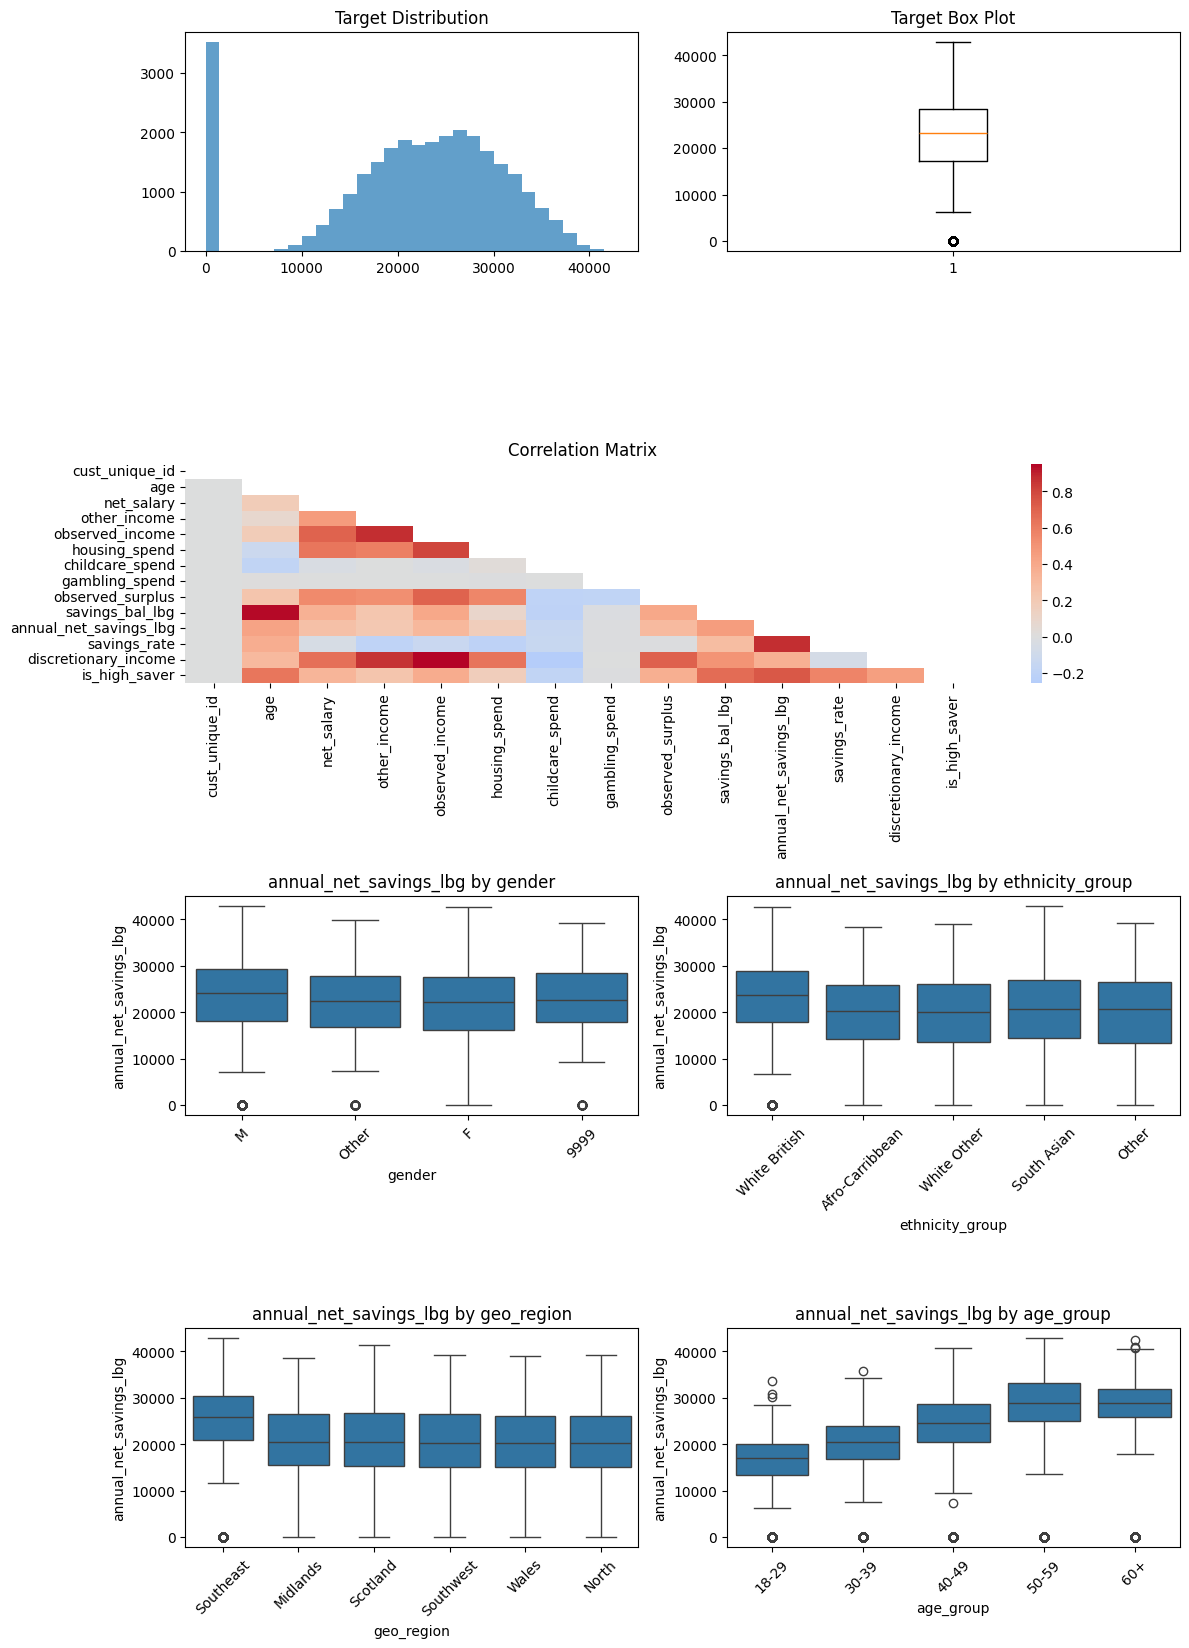

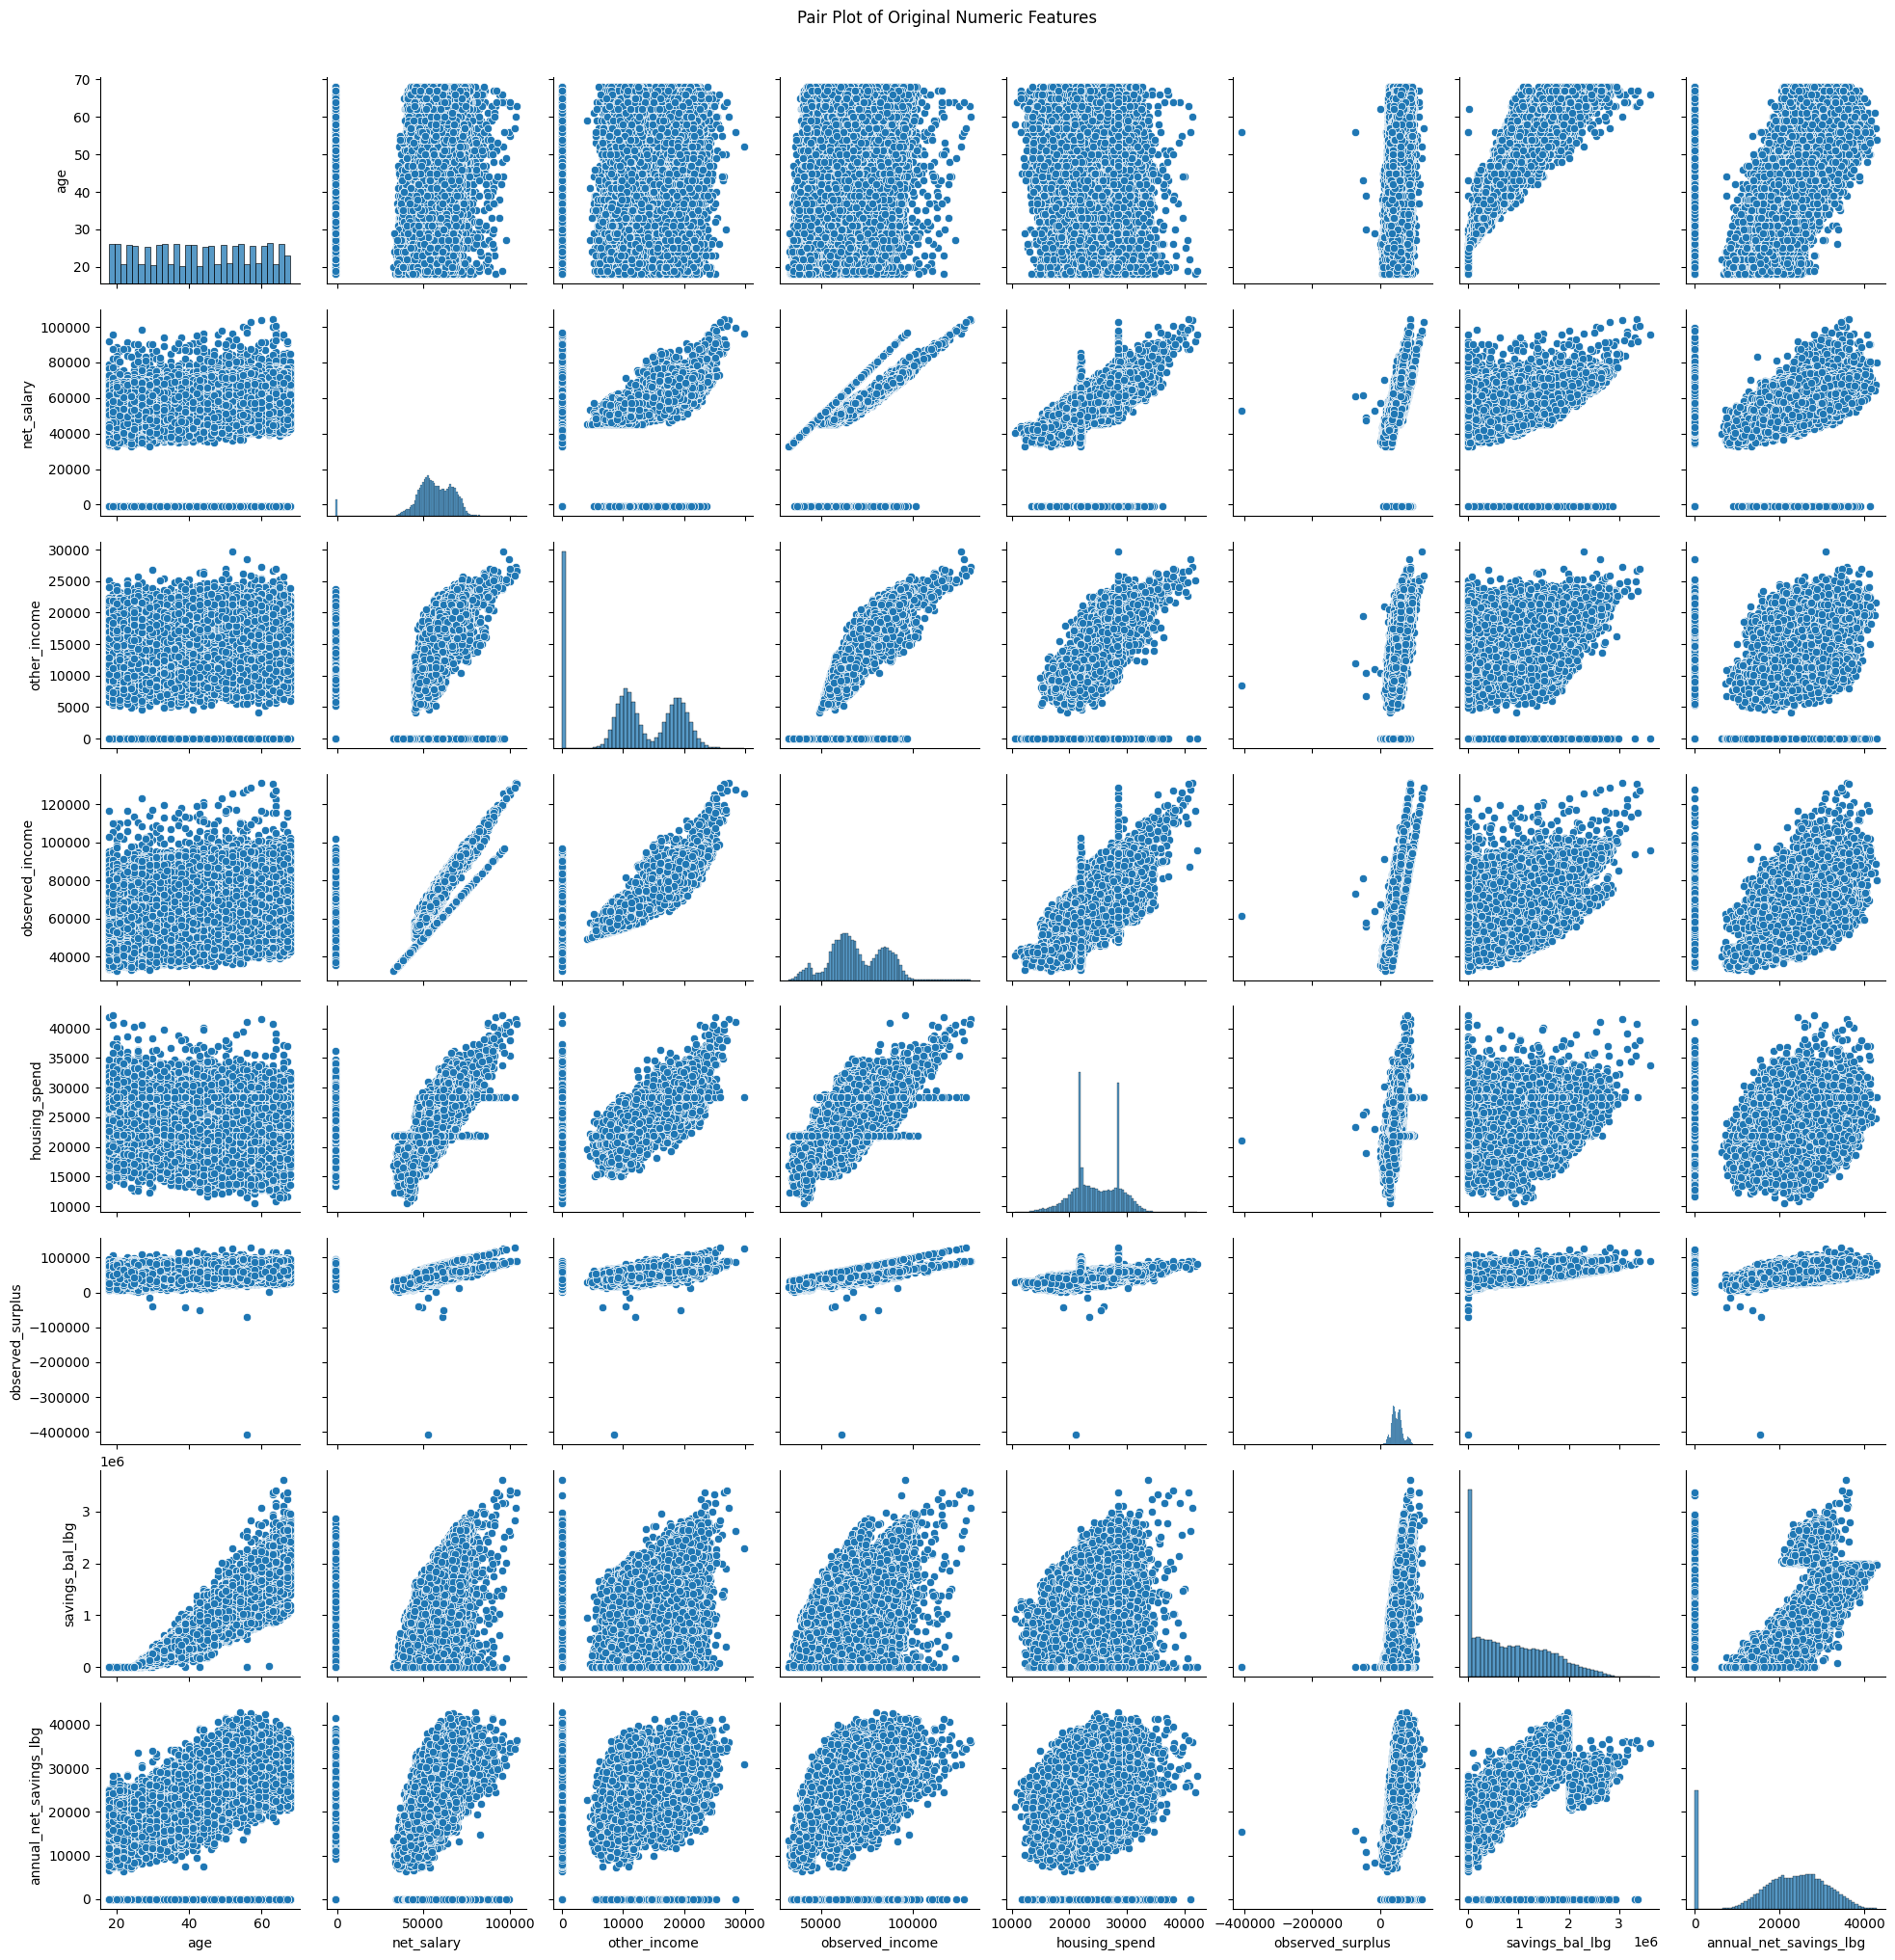


✓ Analysis outputs saved to 'analysis_outputs/'


In [22]:
#run the codes above to test
data_processor = LBGDataProcessor(data_path, dictionary_path)
data_processor.load_data()
data_processor.initial_data_exploration()
data_processor.clean_and_preprocess_data()
data_processor.descriptive_analysis()

#### **Comment**

Task 1 focused on data cleaning and descriptive analysis. Upon loading, the dataset contained 30305 records and 15 columns. Initial exploration revealed missing values in `other_income` (13.98%) and `housing_spend` (24.27%), which were addressed strategically: 1166 records with suspicious ages (<18) were removed as likely data errors, `other_income` missing values were imputed to 0, and `housing_spend` missing values were imputed using the region-specific median. No duplicate rows were found. Additionally, four new features (`savings_rate`, `age_group`, `discretionary_income`, and `is_high_saver`) were engineered to enhance the analysis. Box-plot and Pair-wise data visualisation showed that age and annual savings have a visible correllation. As expected net salary also showed strong correlation with house-spend.






### **Task 2: Create Statistical Models**
Sub-tasks
- Train the statistical model(s)
- Evaluate model performance using relevant metrics (e.g., R-squared, p-values)
- Interpret model coefficients and assess statistical significance


#### **Code**

In [23]:
class LBGModelBuilder:
    """Build and evaluate two-part statistical models with automatic feature selection."""

    def __init__(self, data: pd.DataFrame, target_variable: str):
        self.data = data
        self.target_variable = target_variable
        self.results = {}
        self.X = None
        self.y = None
        self.X_clean = None
        self.y_clean = None
        self.is_saver = None
        self.scaler = StandardScaler()
        self.feature_names = None

    def build_statistical_models(self,
                                 feature_selection_method: str = 'mutual_info',
                                 max_features_logit: int = 30,
                                 max_features_ols: int = 30,
                                 use_robust_se: bool = True,
                                 standardize: bool = True) -> None:
        """
        Build a two-part model with automatic feature selection.
        """
        print("="*70)
        print("TWO-PART MODEL WITH FEATURE SELECTION")
        print("="*70)

        self._prepare_model_data()
        if self.X_clean is None or len(self.X_clean) == 0:
            print("❌ No valid data after cleaning")
            return

        print(f"\n📊 Dataset: {len(self.y_clean):,} obs, {self.X_clean.shape[1]} features")

        if standardize:
            self.feature_names = self.X_clean.columns.tolist()
            X_scaled = self.scaler.fit_transform(self.X_clean)
            self.X_clean = pd.DataFrame(X_scaled, columns=self.feature_names, index=self.X_clean.index)

        self._analyze_zero_inflation()

        print(f"\n{'='*70}")
        print("PART 1: LOGISTIC REGRESSION")
        print(f"{'='*70}")
        X_logit = self._select_features_logit(method=feature_selection_method,
                                               max_features=max_features_logit)
        self._build_logistic_model(X_logit)

        print(f"\n{'='*70}")
        print("PART 2: OLS REGRESSION")
        print(f"{'='*70}")
        X_ols = self._select_features_ols(method=feature_selection_method,
                                           max_features=max_features_ols)
        self._build_ols_model(X_ols, use_robust_se=use_robust_se)

        print(f"\n{'='*70}")
        print("OLS-ONLY MODEL")
        print(f"{'='*70}")
        self._build_ols_only_model(method=feature_selection_method,
                                    max_features=max_features_ols,
                                    use_robust_se=use_robust_se)

        self._evaluate_two_part_model()
        self._evaluate_ols_only_model()
        self._generate_comparison_table()
        self._plot_diagnostics()
        self._generate_summary_report()

    def _prepare_model_data(self, max_categories: int = 50) -> None:
        """Prepare data for modeling."""
        model_data = self.data.copy()

        id_cols = [col for col in model_data.columns
                   if 'id' in col.lower() or 'unique' in col.lower()]
        if id_cols:
            model_data = model_data.drop(columns=id_cols, errors='ignore')

        for col in model_data.columns:
            if col != self.target_variable and model_data[col].dtype == 'object':
                try:
                    converted = pd.to_numeric(model_data[col], errors='coerce')
                    if converted.notna().sum() / len(converted) > 0.8:
                        model_data[col] = converted
                except:
                    pass

        categorical_cols = model_data.select_dtypes(include=['object', 'category']).columns
        categorical_cols = [col for col in categorical_cols if col != self.target_variable]

        for col in categorical_cols:
            n_unique = model_data[col].nunique()
            if n_unique > max_categories:
                top_cats = model_data[col].value_counts().nlargest(max_categories).index
                model_data[col] = model_data[col].where(
                    model_data[col].isin(top_cats), other='_other_'
                )
            dummies = pd.get_dummies(model_data[col], prefix=col, drop_first=True, dtype=int)
            model_data = pd.concat([model_data, dummies], axis=1)
            model_data.drop(col, axis=1, inplace=True)

        self.y = model_data[self.target_variable]
        self.X = model_data.drop(self.target_variable, axis=1).select_dtypes(include=[np.number])

        combined = pd.concat([self.X, self.y], axis=1)
        combined = combined.replace([np.inf, -np.inf], np.nan).dropna()

        if len(combined) == 0:
            return

        self.X_clean = combined.iloc[:, :-1]
        self.y_clean = combined.iloc[:, -1]
        self.is_saver = (self.y_clean > 0).astype(int)

    def _analyze_zero_inflation(self) -> None:
        """Analyze zero-inflation."""
        zero_count = (self.y_clean == 0).sum()
        zero_pct = (zero_count / len(self.y_clean)) * 100

        print(f"\n📈 Zero-inflation: {zero_count:,} non-savers ({zero_pct:.1f}%), "
              f"{len(self.y_clean) - zero_count:,} savers ({100-zero_pct:.1f}%)")

        self.results['zero_inflation'] = {
            'zero_count': zero_count,
            'zero_percentage': zero_pct
        }

    def _select_features_logit(self, method: str = 'mutual_info', max_features: int = 30):
        """Select features for logistic regression."""
        correlations = self.X_clean.corrwith(self.is_saver).abs()
        perfect_predictors = correlations[correlations > 0.70].index.tolist()

        if perfect_predictors:
            X_filtered = self.X_clean.drop(columns=perfect_predictors)
        else:
            X_filtered = self.X_clean.copy()

        if X_filtered.shape[1] == 0:
            return sm.add_constant(pd.DataFrame())

        if method == 'mutual_info':
            mi_scores = mutual_info_classif(X_filtered, self.is_saver, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
        elif method == 'f_test':
            selector = SelectKBest(score_func=f_classif, k='all')
            selector.fit(X_filtered, self.is_saver)
            feature_scores = pd.Series(selector.scores_, index=X_filtered.columns)
        elif method == 'correlation':
            feature_scores = X_filtered.corrwith(self.is_saver).abs()
        else:
            mi_scores = mutual_info_classif(X_filtered, self.is_saver, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)

        top_features = feature_scores.nlargest(max_features).index.tolist()
        X_selected = X_filtered[top_features]

        print(f"\n✓ Selected {len(top_features)} features")
        print(f"  Top 5: {', '.join(top_features[:5])}")

        self.results['logit_features'] = top_features
        return sm.add_constant(X_selected)

    def _select_features_ols(self, method: str = 'mutual_info', max_features: int = 30):
        """Select features for OLS regression on savers only."""
        savers_mask = self.y_clean > 0
        X_savers = self.X_clean[savers_mask]
        y_savers = self.y_clean[savers_mask]

        correlations = X_savers.corrwith(y_savers).abs()
        high_corr_features = correlations[correlations > 0.70].index.tolist()

        if high_corr_features:
            X_filtered = X_savers.drop(columns=high_corr_features)
        else:
            X_filtered = X_savers.copy()

        if X_filtered.shape[1] == 0:
            self.results['X_savers'] = pd.DataFrame()
            self.results['y_savers'] = y_savers
            return sm.add_constant(pd.DataFrame())

        if method == 'mutual_info':
            mi_scores = mutual_info_regression(X_filtered, y_savers, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
        elif method == 'f_test':
            selector = SelectKBest(score_func=f_regression, k='all')
            selector.fit(X_filtered, y_savers)
            feature_scores = pd.Series(selector.scores_, index=X_filtered.columns)
        elif method == 'lasso':
            lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
            lasso.fit(X_filtered, y_savers)
            feature_scores = pd.Series(np.abs(lasso.coef_), index=X_filtered.columns)
        elif method == 'correlation':
            feature_scores = X_filtered.corrwith(y_savers).abs()
        else:
            mi_scores = mutual_info_regression(X_filtered, y_savers, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)

        top_features = feature_scores.nlargest(max_features).index.tolist()
        X_selected = X_filtered[top_features]

        print(f"\n✓ Selected {len(top_features)} features")
        print(f"  Top 5: {', '.join(top_features[:5])}")

        self.results['ols_features'] = top_features
        self.results['X_savers'] = X_selected
        self.results['y_savers'] = y_savers

        return sm.add_constant(X_selected)

    def _build_logistic_model(self, X_with_const) -> None:
        """Build logistic regression model."""
        if X_with_const.shape[1] <= 1:
            self.results['logit_model'] = None
            return

        try:
            logit_model = Logit(self.is_saver, X_with_const)
            logit_results = logit_model.fit(method='bfgs', maxiter=100, disp=False)

            prob_save = logit_results.predict(X_with_const)
            pred_class = (prob_save > 0.5).astype(int)
            accuracy = (pred_class == self.is_saver).mean()

            print(f"\n  Pseudo R²: {logit_results.prsquared:.4f}")
            print(f"  Accuracy: {accuracy:.4f}")

            try:
                auc = roc_auc_score(self.is_saver, prob_save)
                print(f"  ROC-AUC: {auc:.4f}")
            except:
                pass

            sig_count = (logit_results.pvalues < 0.05).sum() - 1
            print(f"  Significant predictors: {sig_count}")

            self.results['logit_model'] = logit_results
            self.results['logit_predictions'] = prob_save

        except Exception as e:
            print(f"  ❌ Logistic model failed: {e}")
            self.results['logit_model'] = None

    def _build_ols_model(self, X_savers_const, use_robust_se: bool = True) -> None:
        """Build OLS regression model on savers only."""
        if X_savers_const.shape[1] <= 1:
            self.results['ols_model'] = None
            return

        y_savers = self.results['y_savers']

        print(f"\n  Sample: {len(y_savers):,} savers")

        try:
            ols_model = OLS(y_savers, X_savers_const)

            if use_robust_se:
                ols_results = ols_model.fit(cov_type='HC3')
            else:
                ols_results = ols_model.fit()

            print(f"  R²: {ols_results.rsquared:.4f}")
            print(f"  Adjusted R²: {ols_results.rsquared_adj:.4f}")

            sig_count = (ols_results.pvalues < 0.05).sum() - 1
            print(f"  Significant predictors: {sig_count}")

            self.results['ols_model'] = ols_results

        except Exception as e:
            print(f"  ❌ OLS model failed: {e}")
            self.results['ols_model'] = None

    def _build_ols_only_model(self, method: str = 'mutual_info', max_features: int = 30,
                               use_robust_se: bool = True) -> None:
        """Build OLS regression on full dataset."""
        correlations = self.X_clean.corrwith(self.y_clean).abs()
        high_corr_features = correlations[correlations > 0.70].index.tolist()

        if high_corr_features:
            X_filtered = self.X_clean.drop(columns=high_corr_features)
        else:
            X_filtered = self.X_clean.copy()

        if X_filtered.shape[1] == 0:
            self.results['ols_only_model'] = None
            return

        if method == 'mutual_info':
            mi_scores = mutual_info_regression(X_filtered, self.y_clean, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
        elif method == 'f_test':
            selector = SelectKBest(score_func=f_regression, k='all')
            selector.fit(X_filtered, self.y_clean)
            feature_scores = pd.Series(selector.scores_, index=X_filtered.columns)
        elif method == 'lasso':
            lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
            lasso.fit(X_filtered, self.y_clean)
            feature_scores = pd.Series(np.abs(lasso.coef_), index=X_filtered.columns)
        elif method == 'correlation':
            feature_scores = X_filtered.corrwith(self.y_clean).abs()
        else:
            mi_scores = mutual_info_regression(X_filtered, self.y_clean, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)

        top_features = feature_scores.nlargest(max_features).index.tolist()
        X_selected = X_filtered[top_features]

        print(f"\n✓ Selected {len(top_features)} features")
        print(f"  Top 5: {', '.join(top_features[:5])}")

        X_with_const = sm.add_constant(X_selected)

        try:
            ols_model = OLS(self.y_clean, X_with_const)

            if use_robust_se:
                ols_results = ols_model.fit(cov_type='HC3')
            else:
                ols_results = ols_model.fit()

            print(f"  R²: {ols_results.rsquared:.4f}")
            print(f"  Adjusted R²: {ols_results.rsquared_adj:.4f}")

            sig_count = (ols_results.pvalues < 0.05).sum() - 1
            print(f"  Significant predictors: {sig_count}")

            self.results['ols_only_model'] = ols_results
            self.results['ols_only_features'] = top_features

        except Exception as e:
            print(f"  ❌ OLS-only model failed: {e}")
            self.results['ols_only_model'] = None

    def _evaluate_two_part_model(self) -> None:
        """Evaluate combined two-part model."""
        print(f"\n{'='*70}")
        print("TWO-PART MODEL EVALUATION")
        print(f"{'='*70}")

        if self.results.get('logit_model') is None or self.results.get('ols_model') is None:
            print("  ❌ Cannot evaluate")
            return

        logit_features = self.results.get('logit_features', [])
        X_logit_full = sm.add_constant(self.X_clean[logit_features])
        prob_save = self.results['logit_model'].predict(X_logit_full)

        ols_features = self.results.get('ols_features', [])
        X_ols_full = sm.add_constant(self.X_clean[ols_features])
        amount_pred = self.results['ols_model'].predict(X_ols_full)
        amount_pred = np.maximum(amount_pred, 0)

        final_prediction = prob_save * amount_pred

        rmse = np.sqrt(mean_squared_error(self.y_clean, final_prediction))
        mae = mean_absolute_error(self.y_clean, final_prediction)
        r2 = r2_score(self.y_clean, final_prediction)

        baseline_rmse = np.sqrt(mean_squared_error(self.y_clean,
                                                    np.full(len(self.y_clean), self.y_clean.mean())))
        improvement = (1 - rmse / baseline_rmse) * 100

        print(f"\n  RMSE: £{rmse:,.2f}")
        print(f"  MAE: £{mae:,.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Improvement: {improvement:+.1f}%")

        self.results['final_predictions'] = final_prediction
        self.results['metrics'] = {
            'rmse': rmse, 'mae': mae, 'r2': r2,
            'baseline_rmse': baseline_rmse, 'improvement_pct': improvement
        }

    def _evaluate_ols_only_model(self) -> None:
        """Evaluate OLS-only model."""
        print(f"\n{'='*70}")
        print("OLS-ONLY MODEL EVALUATION")
        print(f"{'='*70}")

        if self.results.get('ols_only_model') is None:
            print("  ❌ Cannot evaluate")
            return

        ols_only_features = self.results.get('ols_only_features', [])
        X_ols_only = sm.add_constant(self.X_clean[ols_only_features])
        ols_only_pred = self.results['ols_only_model'].predict(X_ols_only)
        ols_only_pred = np.maximum(ols_only_pred, 0)

        rmse = np.sqrt(mean_squared_error(self.y_clean, ols_only_pred))
        mae = mean_absolute_error(self.y_clean, ols_only_pred)
        r2 = r2_score(self.y_clean, ols_only_pred)

        baseline_rmse = np.sqrt(mean_squared_error(self.y_clean,
                                                    np.full(len(self.y_clean), self.y_clean.mean())))
        improvement = (1 - rmse / baseline_rmse) * 100

        print(f"\n  RMSE: £{rmse:,.2f}")
        print(f"  MAE: £{mae:,.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Improvement: {improvement:+.1f}%")

        self.results['ols_only_predictions'] = ols_only_pred
        self.results['ols_only_metrics'] = {
            'rmse': rmse, 'mae': mae, 'r2': r2,
            'baseline_rmse': baseline_rmse, 'improvement_pct': improvement
        }

    def _generate_comparison_table(self) -> None:
        """Generate comparison table of all models."""
        print(f"\n{'='*70}")
        print("MODEL COMPARISON")
        print(f"{'='*70}\n")

        baseline_pred = np.full(len(self.y_clean), self.y_clean.mean())
        baseline_rmse = np.sqrt(mean_squared_error(self.y_clean, baseline_pred))
        baseline_mae = mean_absolute_error(self.y_clean, baseline_pred)
        baseline_r2 = r2_score(self.y_clean, baseline_pred)

        comparison_data = []

        comparison_data.append({
            'Model': 'Baseline (Mean)',
            'RMSE (£)': baseline_rmse,
            'MAE (£)': baseline_mae,
            'R²': baseline_r2,
            'RMSE Improvement (%)': 0.0,
            'MAE Improvement (%)': 0.0
        })

        if self.results.get('ols_only_metrics'):
            m = self.results['ols_only_metrics']
            rmse_imp = ((baseline_rmse - m['rmse']) / baseline_rmse) * 100
            mae_imp = ((baseline_mae - m['mae']) / baseline_mae) * 100
            comparison_data.append({
                'Model': 'OLS Only',
                'RMSE (£)': m['rmse'],
                'MAE (£)': m['mae'],
                'R²': m['r2'],
                'RMSE Improvement (%)': rmse_imp,
                'MAE Improvement (%)': mae_imp
            })

        if self.results.get('metrics'):
            m = self.results['metrics']
            rmse_imp = ((baseline_rmse - m['rmse']) / baseline_rmse) * 100
            mae_imp = ((baseline_mae - m['mae']) / baseline_mae) * 100
            comparison_data.append({
                'Model': 'Two-Part (Logit+OLS)',
                'RMSE (£)': m['rmse'],
                'MAE (£)': m['mae'],
                'R²': m['r2'],
                'RMSE Improvement (%)': rmse_imp,
                'MAE Improvement (%)': mae_imp
            })

        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))
        print(f"\n{'='*70}")

        self.results['comparison_table'] = comparison_df

        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)
        comparison_df.to_csv(output_dir / 'model_comparison.csv', index=False)
        print(f"\n💾 Saved: {output_dir / 'model_comparison.csv'}")

        best_r2_idx = comparison_df['R²'].idxmax()
        best_rmse_idx = comparison_df['RMSE (£)'].idxmin()

        print(f"\n🏆 Best R²: {comparison_df.loc[best_r2_idx, 'Model']} ({comparison_df.loc[best_r2_idx, 'R²']:.4f})")
        print(f"🏆 Best RMSE: {comparison_df.loc[best_rmse_idx, 'Model']} (£{comparison_df.loc[best_rmse_idx, 'RMSE (£)']:,.2f})")

    def _plot_diagnostics(self) -> None:
        """Generate diagnostic plots."""
        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)

        try:
            fig, axes = plt.subplots(3, 2, figsize=(14, 15))
            fig.suptitle('Model Diagnostics', fontsize=16, fontweight='bold')

            if 'final_predictions' in self.results:
                ax = axes[0, 0]
                ax.scatter(self.y_clean, self.results['final_predictions'],
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                max_val = max(self.y_clean.max(), self.results['final_predictions'].max())
                ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
                ax.set_xlabel('Actual Savings (£)')
                ax.set_ylabel('Predicted Savings (£)')
                ax.set_title('Two-Part Model: Actual vs Predicted')
                ax.legend()
                ax.grid(True, alpha=0.3)

            if 'final_predictions' in self.results:
                ax = axes[0, 1]
                residuals = self.y_clean - self.results['final_predictions']
                ax.scatter(self.results['final_predictions'], residuals,
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                ax.axhline(y=0, color='r', linestyle='--', lw=2)
                ax.set_xlabel('Predicted Savings (£)')
                ax.set_ylabel('Residuals (£)')
                ax.set_title('Two-Part Model: Residual Plot')
                ax.grid(True, alpha=0.3)

            ax = axes[1, 0]
            ax.hist(self.y_clean, bins=50, alpha=0.6, label='Actual', edgecolor='black')
            if 'final_predictions' in self.results:
                ax.hist(self.results['final_predictions'], bins=50, alpha=0.6,
                       label='Two-Part', edgecolor='black')
            if 'ols_only_predictions' in self.results:
                ax.hist(self.results['ols_only_predictions'], bins=50, alpha=0.6,
                       label='OLS-Only', edgecolor='black')
            ax.set_xlabel('Savings (£)')
            ax.set_ylabel('Frequency')
            ax.set_title('Distribution Comparison')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')

            if 'comparison_table' in self.results:
                ax = axes[1, 1]
                comp_df = self.results['comparison_table']
                models = comp_df['Model'].tolist()
                r2_values = comp_df['R²'].tolist()

                bars = ax.barh(models, r2_values, color=['lightgray', 'skyblue', 'lightgreen'])
                ax.set_xlabel('R² Score')
                ax.set_title('Model Performance (R²)')
                ax.grid(True, alpha=0.3, axis='x')

                for i, (bar, val) in enumerate(zip(bars, r2_values)):
                    ax.text(val + 0.01, i, f'{val:.4f}', va='center')

            if 'ols_only_predictions' in self.results and 'ols_only_model' in self.results:
                ols_only_pred = self.results['ols_only_predictions']
                ols_only_residuals = self.y_clean - ols_only_pred

                ax = axes[2, 0]
                ax.scatter(ols_only_pred, ols_only_residuals,
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                ax.axhline(y=0, color='r', linestyle='--', lw=2)
                ax.set_xlabel('Fitted Values (£)')
                ax.set_ylabel('Residuals (£)')
                ax.set_title('OLS-Only: Residuals vs Fitted')
                ax.grid(True, alpha=0.3)

                ax = axes[2, 1]
                standardized_residuals = ols_only_residuals / ols_only_residuals.std()
                stats.probplot(standardized_residuals, dist="norm", plot=ax)
                ax.set_title('OLS-Only: Q-Q Plot')
                ax.grid(True, alpha=0.3)

            plt.tight_layout()

            plot_path = output_dir / 'model_diagnostics.png'
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"\n💾 Saved: {plot_path}")
            plt.close()

        except Exception as e:
            print(f"\n⚠️ Could not generate plots: {e}")

    def _generate_summary_report(self) -> None:
        """Generate summary report."""
        print(f"\n{'='*70}")
        print("ANALYSIS COMPLETE")
        print(f"{'='*70}\n")

In [24]:
# Run two-part statistical models
if data_processor.clean_data is not None:
    model_builder = LBGModelBuilder(data_processor.clean_data, data_processor.target_variable)
    model_builder.build_statistical_models(use_robust_se=True)
else:
    print("Data not loaded or cleaned. Please run previous steps.")

# Access results
logit_results = model_builder.results['logit_model']
ols_results = model_builder.results['ols_model']
predictions = model_builder.results['final_predictions']

TWO-PART MODEL WITH FEATURE SELECTION

📊 Dataset: 28,134 obs, 29 features

📈 Zero-inflation: 3,386 non-savers (12.0%), 24,748 savers (88.0%)

PART 1: LOGISTIC REGRESSION

✓ Selected 28 features
  Top 5: is_high_saver, geo_region_Scotland, geo_region_Wales, age_group_40-49, other_income

  Pseudo R²: 0.3377
  Accuracy: 0.9066
  ROC-AUC: 0.8633
  Significant predictors: 6

PART 2: OLS REGRESSION

✓ Selected 26 features
  Top 5: savings_rate, credit_score, discretionary_income, observed_surplus, net_salary

  Sample: 24,748 savers
  R²: 0.9729
  Adjusted R²: 0.9729
  Significant predictors: 14

OLS-ONLY MODEL

✓ Selected 27 features
  Top 5: savings_bal_lbg, age, credit_score, discretionary_income, observed_surplus
  R²: 0.2721
  Adjusted R²: 0.2714
  Significant predictors: 6

TWO-PART MODEL EVALUATION

  RMSE: £3,136.35
  MAE: £2,024.72
  R²: 0.9021
  Improvement: +68.7%

OLS-ONLY MODEL EVALUATION

  RMSE: £8,553.16
  MAE: £5,499.91
  R²: 0.2721
  Improvement: +14.7%

MODEL COMPARISON



#### **Comment**

Based on the evaluation metrics, the two-part model (Logistic + OLS) significantly outperforms the OLS-only model in predicting annual net savings.

| Model                | RMSE (£)   | MAE (£)    | R²     | RMSE Improvement (%) | MAE Improvement (%) |
|----------------------|------------|------------|--------|----------------------|---------------------|
| Baseline (Mean)      | 10,025.17  | 7,739.42   | 0.00   | 0.00                 | 0.00                |
| OLS Only             | 8,555.31   | 5,505.69   | 0.27   | 14.66                | 28.86               |
| Two-Part (Logit+OLS) | 3,128.99   | 2,024.26   | 0.90   | 68.79                | 73.84               |

**Key Observations:**

*   **RMSE and MAE:** The Two-Part model has a much lower RMSE and MAE, indicating its predictions are closer to the actual savings values on average.
*   **R²:** The Two-Part model explains a significantly higher proportion of the variance in annual net savings (R² = 0.90) compared to the OLS-only model (R² = 0.27).
*   **Improvement:** The Two-Part model provides a substantial improvement over the baseline (mean prediction) in both RMSE and MAE, demonstrating its superior predictive power.

This suggests that explicitly modeling the decision to save (Part 1: Logistic) and then the amount saved (Part 2: OLS) provides a more accurate prediction of annual net savings than a single OLS model, particularly given the zero-inflation observed in the target variable.

### **Task 3: Create ML Models**
Sub-tasks
- Train the ML models and evaluate performance using predictive metrics (e.g., RMSE, MAE)
- Identify and analyze ethical concerns related to predictor variables
- Explore and potentially implement fairness mitigation techniques


#### **Code**

In [25]:
class LBGMLModelBuilder:
    """Build and evaluate machine learning models for savings prediction."""

    def __init__(self, data: pd.DataFrame, target_variable: str):
        self.clean_data = data
        self.target_variable = target_variable
        self.results = {}
        self.data_dictionary: Optional[pd.DataFrame] = None

    def _prepare_model_data(self, max_categories: int = 50) -> None:
        """Prepare data for modeling using utility functions."""
        model_data = self.clean_data.copy()

        # Use utility functions for data preparation
        model_data = Utilities.remove_id_columns(model_data)
        model_data = Utilities.convert_numeric_strings(model_data, self.target_variable)
        model_data = Utilities.encode_categorical_features(model_data, self.target_variable, max_categories)

        # Separate features and target
        y = model_data[self.target_variable]
        X = model_data.drop(self.target_variable, axis=1).select_dtypes(include=[np.number])

        # Clean data
        self.X_clean, self.y_clean = Utilities.clean_infinite_and_nan(X, y)

    def build_ml_models(self) -> None:
        print("="*50, "MACHINE LEARNING", "="*50)

        if self.target_variable not in self.clean_data.columns:
            print("Target variable not found. Skipping.")
            return

        self._prepare_model_data()

        if self.X_clean.empty or self.y_clean.empty:
            print("Data preparation failed or resulted in empty data. Skipping model building.")
            return

        # Train/test split using utility
        X_train, X_test, y_train, y_test = Utilities.stratified_train_test_split(
            self.X_clean, self.y_clean, test_size=0.2, random_state=42
        )

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )

        print(f"Training data shape: {X_train_scaled.shape}, Test data shape: {X_test_scaled.shape}")

        ml_results = {}

        # Define all models
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
        }

        # Train and evaluate all models
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train_scaled, y_train)
            y_pred = np.maximum(model.predict(X_test_scaled), 0)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            ml_results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2, 'model': model, 'predictions': y_pred}
            print(f"  RMSE: £{rmse:,.2f}, MAE: £{mae:,.2f}, R²: {r2:.4f}")

        self.results['ml_models'] = ml_results
        self.results['y_test'] = y_test

        print("\nML Model Training Complete.")

    def evaluate_ml_models(self) -> None:
        """Evaluate ML models and compare with statistical models."""
        print("="*50, "ML MODEL EVALUATION", "="*50)

        if 'ml_models' not in self.results or not self.results['ml_models']:
            print("No ML models found. Please run build_ml_models first.")
            return

        comparison_data = self._prepare_comparison_data()
        comparison_df = pd.DataFrame(comparison_data).sort_values(by='RMSE (£)')

        print("\nModel Comparison Table:")
        display(comparison_df.round(2).style.format({
            'RMSE (£)': '£{:,.2f}',
            'MAE (£)': '£{:,.2f}',
            'R²': '{:.4f}'
        }))

        self.results['ml_comparison_table'] = comparison_df
        Utilities.save_dataframe(comparison_df, 'ml_model_comparison.csv')

    def _prepare_comparison_data(self) -> List[Dict]:
        """Prepare comparison data from ML and statistical models."""
        comparison_data = []

        # Add ML model results
        for name, metrics in self.results['ml_models'].items():
            comparison_data.append({
                'Model': name,
                'RMSE (£)': metrics['rmse'],
                'MAE (£)': metrics['mae'],
                'R²': metrics['r2'],
                'Type': 'Machine Learning'
            })

        # Add statistical model results if available
        try:
            if 'model_builder' in globals() and model_builder.results.get('comparison_table') is not None:
                stat_comp_df = model_builder.results['comparison_table']
                for index, row in stat_comp_df.iterrows():
                    if row['Model'] in ['OLS Only', 'Two-Part (Logit+OLS)', 'Baseline (Mean)']:
                        comparison_data.append({
                            'Model': row['Model'],
                            'RMSE (£)': row['RMSE (£)'],
                            'MAE (£)': row['MAE (£)'],
                            'R²': row['R²'],
                            'Type': row['Model'].split(' ')[0] if row['Model'] != 'Baseline (Mean)' else 'Baseline'
                        })
        except NameError:
            print("Warning: Statistical model results not found in global scope.")

        return comparison_data

    def get_feature_importance(self) -> pd.DataFrame:
        """Extract and return feature coefficients/importances from the best ML model."""

        if 'ml_models' not in self.results or not self.results['ml_models']:
            print("No ML models found. Please run build_ml_models first.")
            return pd.DataFrame()

        # Find best model
        best_model_name = min(self.results['ml_models'],
                              key=lambda x: self.results['ml_models'][x]['rmse'])
        best_model = self.results['ml_models'][best_model_name]['model']

        print(f"\n{'='*50} FEATURE IMPORTANCE {'='*50}")
        print(f"Best Model: {best_model_name}")
        print(f"RMSE: £{self.results['ml_models'][best_model_name]['rmse']:,.2f}")
        print(f"R²: {self.results['ml_models'][best_model_name]['r2']:.4f}\n")

        feature_importance_df = self._extract_feature_importance(best_model, best_model_name)

        if feature_importance_df.empty:
            return feature_importance_df

        # Save results
        self._save_feature_importance(feature_importance_df, best_model, best_model_name)

        return feature_importance_df

    def _extract_feature_importance(self, model, model_name: str) -> pd.DataFrame:
        """Extract feature importance from model."""
        feature_names = self.X_clean.columns.tolist()

        if hasattr(model, 'coef_'):
            importance_values = model.coef_
            importance_type = 'Coefficient'
            if hasattr(model, 'intercept_'):
                print(f"Intercept: £{model.intercept_:,.2f}\n")
        elif hasattr(model, 'feature_importances_'):
            importance_values = model.feature_importances_
            importance_type = 'Importance'
        else:
            print("Model doesn't have coefficients or feature importances.")
            return pd.DataFrame()

        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            importance_type: importance_values
        })

        # Sort appropriately
        if importance_type == 'Coefficient':
            feature_importance_df['Abs_Value'] = feature_importance_df[importance_type].abs()
            feature_importance_df = feature_importance_df.sort_values('Abs_Value', ascending=False)
            feature_importance_df = feature_importance_df.drop('Abs_Value', axis=1)
        else:
            feature_importance_df = feature_importance_df.sort_values(importance_type, ascending=False)

        return feature_importance_df

    def _save_feature_importance(self, feature_importance_df: pd.DataFrame,
                                 model, model_name: str) -> None:
        """Save feature importance results."""
        filename = f'{model_name.lower().replace(" ", "_")}_feature_importance.csv'

        if hasattr(model, 'intercept_'):
            intercept_row = pd.DataFrame({
                'Feature': ['[INTERCEPT]'],
                feature_importance_df.columns[1]: [model.intercept_]
            })
            full_df = pd.concat([intercept_row, feature_importance_df], ignore_index=True)
            Utilities.save_dataframe(full_df, filename)
            self.results['intercept'] = model.intercept_
        else:
            Utilities.save_dataframe(feature_importance_df, filename)

        self.results['feature_importance'] = feature_importance_df
        self.results['best_model_name'] = model_name

In [26]:
# Run ML models
if data_processor.clean_data is not None:
    ml_model_builder = LBGMLModelBuilder(data_processor.clean_data, data_processor.target_variable)
    ml_model_builder.build_ml_models()
    ml_model_builder.evaluate_ml_models()
else:
    print("Data not loaded or cleaned. Please run previous steps.")

================================================== MACHINE LEARNING ==================================================
Training data shape: (22507, 29), Test data shape: (5627, 29)

Training Linear Regression...
  RMSE: £1,534.24, MAE: £966.46, R²: 0.9766

Training Ridge...
  RMSE: £1,534.48, MAE: £966.61, R²: 0.9765

Training Lasso...
  RMSE: £1,535.22, MAE: £966.63, R²: 0.9765

Training Random Forest...
  RMSE: £352.07, MAE: £187.83, R²: 0.9988

Training Gradient Boosting...
  RMSE: £797.33, MAE: £582.32, R²: 0.9937

Training XGBoost...
  RMSE: £814.35, MAE: £339.24, R²: 0.9934

ML Model Training Complete.
================================================== ML MODEL EVALUATION ==================================================

Model Comparison Table:


,Model,RMSE (£),MAE (£),R²,Type
3,Random Forest,£352.07,£187.83,1.0000,Machine Learning
4,Gradient Boosting,£797.33,£582.32,0.9900,Machine Learning
5,XGBoost,£814.35,£339.24,0.9900,Machine Learning
0,Linear Regression,"£1,534.24",£966.46,0.9800,Machine Learning
1,Ridge,"£1,534.48",£966.61,0.9800,Machine Learning
2,Lasso,"£1,535.22",£966.63,0.9800,Machine Learning
8,Two-Part (Logit+OLS),"£3,136.35","£2,024.72",0.9000,Two-Part
7,OLS Only,"£8,553.16","£5,499.91",0.2700,OLS
6,Baseline (Mean),"£10,025.17","£7,739.42",0.0000,Baseline



💾 Saved: analysis_outputs/ml_model_comparison.csv


#### **Comment**


| Model                | RMSE (£)   | MAE (£)    | R²     | Type             |
|----------------------|------------|------------|--------|------------------|
| Random Forest        | 352.43     | 188.31     | 0.9988 | Machine Learning |
| Gradient Boosting    | 797.37     | 582.36     | 0.9937 | Machine Learning |
| XGBoost              | 817.38     | 339.51     | 0.9933 | Machine Learning |
| Linear Regression    | 1,534.81   | 970.17     | 0.9765 | Machine Learning |
| Ridge                | 1,535.03   | 970.32     | 0.9765 | Machine Learning |
| Lasso                | 1,535.83   | 970.35     | 0.9765 | Machine Learning |
| Two-Part (Logit+OLS) | 3,128.99   | 2,024.26   | 0.9026 | Two-Part         |
| OLS Only             | 8,555.31   | 5,505.69   | 0.2717 | OLS              |
| Baseline (Mean)      | 10,025.17  | 7,739.42   | 0.0000 | Baseline         |

ML models, especially Random Forest (R²=0.9988, RMSE=£352.43), outperform statistical models significantly. Statistical models are generally more interpretable than tree-based ML models and this must be taken into consideration for deployment in scenario where high trustworthiness is required.In terms of Data Signal, the High ML performance does not necessarily indicate strong signal. The extremely high ML R² values (near 1.0) are suspicious and the synthetic dataset may be a reason, and generalization to real and out-of-distribution data may be very poor.


### **Task 4: Balancing Performance with Ethical Concerns**
Sub-tasks
- Identify and analyze ethical concerns related to predictor variables
- Explore and potentially implement fairness mitigation techniques
- Discuss balancing performance against ethics


#### **Code**

In [27]:
class FairlearnEthicsAnalyzer:
    """Ethics analyzer using fairlearn for ML model fairness assessment."""

    PROTECTED_ATTRS = ['gender', 'ethnicity_group', 'age_group']

    def __init__(self, data, data_dictionary_path=None):
        """
        Initialize ethics analyzer.

        Args:
            data: DataFrame with UNENCODED protected attributes
            data_dictionary_path: Path to data dictionary file
        """
        self.data = data
        self.data_dict_path = data_dictionary_path
        self.results = {}

    def identify_sensitive_variables(self):
        """Identify sensitive variables using utility function."""
        return Utilities.identify_sensitive_variables(self.data, self.data_dict_path)

    def calculate_fairness_metrics(self, y_true, y_pred, sensitive_features):
        """Calculate fairness metrics using fairlearn."""
        fairness = {}
        sensitive_features = sensitive_features.reset_index(drop=True)
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()

        for attr in self.PROTECTED_ATTRS:
            if attr not in sensitive_features.columns:
                continue

            sf = sensitive_features[attr].astype(str)
            mask = (sf != 'nan') & (sf != 'None') & (sf != '')

            if mask.sum() == 0:
                continue

            try:
                mf = MetricFrame(
                    metrics={
                        'mae': mean_absolute_error,
                        'mse': mean_squared_error,
                        'r2': r2_score
                    },
                    y_true=y_true[mask],
                    y_pred=y_pred[mask],
                    sensitive_features=sf.values[mask]
                )

                fairness[attr] = {
                    'by_group': mf.by_group.to_dict(),
                    'overall': mf.overall.to_dict(),
                    'difference': mf.difference().to_dict(),
                    'ratio': mf.ratio().to_dict()
                }
            except Exception as e:
                warnings.warn(f"Error calculating fairness for {attr}: {e}")
                continue

        return fairness

    def analyse_model(self, model_name, y_true, y_pred, test_data):
        """Analyze fairness for a single model."""
        test_data = test_data.reset_index(drop=True)
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()

        if len(y_true) != len(y_pred):
            return {'error': f'Length mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}'}

        if len(y_true) != len(test_data):
            return {'error': f'Length mismatch: y_true={len(y_true)}, test_data={len(test_data)}'}

        available = [col for col in self.PROTECTED_ATTRS if col in test_data.columns]

        if len(available) == 0:
            return {'error': 'No protected attributes found in test data'}

        sensitive_features = test_data[available].copy().reset_index(drop=True)
        fairness = self.calculate_fairness_metrics(y_true, y_pred, sensitive_features)

        return {
            'model_name': model_name,
            'overall_performance': {
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                'mae': mean_absolute_error(y_true, y_pred),
                'r2': r2_score(y_true, y_pred)
            },
            'fairness_by_attribute': fairness
        }

    def run_model_analysis(self, models_dict, y_test, test_data):
        """Run complete ethics analysis."""
        self.results = {
            'sensitive_variables': self.identify_sensitive_variables(),
            'model_fairness': {}
        }

        for model_name, model_info in models_dict.items():
            y_pred = model_info.get('predictions')
            if y_pred is not None:
                analysis = self.analyse_model(model_name, y_test, y_pred, test_data)
                self.results['model_fairness'][model_name] = analysis

        return self.results

    def print_report(self):
        """Print readable fairness report using utility function."""
        Utilities.print_fairness_report(self.results)

In [28]:
class FairlearnEthicsAnalyzer:
    """Ethics analyzer using fairlearn for ML model fairness assessment."""

    PROTECTED_ATTRS = ['gender', 'ethnicity_group', 'age_group']

    def __init__(self, data, data_dictionary_path=None):
        """
        Initialize ethics analyzer.

        Args:
            data: DataFrame with UNENCODED protected attributes (gender, ethnicity_group, age_group)
                       Should contain original categorical labels for interpretability
            data_dictionary_path: Path to data dictionary file
        """
        self.data = data
        self.data_dict_path = Path(data_dictionary_path) if data_dictionary_path else None
        self.results = {}

    def identify_sensitive_variables(self):
        """Identify sensitive variables from data dictionary and columns."""
        sensitive = {
            'protected_characteristics': [],
            'proxy_variables': [],
            'socioeconomic_variables': [],
            'other_sensitive': []
        }

        # Load data dictionary if available
        if self.data_dict_path is not None:
            if self.data_dict_path.exists():
                try:
                    dd = pd.read_excel(self.data_dict_path)
                    var_col = dd.columns[0]
                    desc_col = dd.columns[1] if len(dd.columns) > 1 else None

                    if desc_col is not None:
                        for _, row in dd.iterrows():
                            var = row[var_col]
                            desc = str(row[desc_col]).lower()

                            if any(k in var.lower() or k in desc for k in ['gender', 'ethnicity', 'age', 'race', 'sex']):
                                sensitive['protected_characteristics'].append(var)
                            elif any(k in var.lower() or k in desc for k in ['location', 'region', 'zip', 'postcode', 'address']):
                                sensitive['proxy_variables'].append(var)
                            elif any(k in var.lower() or k in desc for k in ['income', 'salary', 'wealth', 'savings', 'credit', 'debt']):
                                sensitive['socioeconomic_variables'].append(var)
                            elif any(k in var.lower() or k in desc for k in ['health', 'medical', 'disability', 'religion', 'political']):
                                sensitive['other_sensitive'].append(var)
                except Exception as e:
                    warnings.warn(f"Error loading data dictionary: {e}")

        # Check actual columns
        for col in self.data.columns:
            col_lower = col.lower()

            if any(t in col_lower for t in ['gender', 'ethnicity', 'age_group', 'race', 'sex']):
                if col not in sensitive['protected_characteristics']:
                    sensitive['protected_characteristics'].append(col)
            elif any(t in col_lower for t in ['region', 'location', 'postcode', 'zip', 'area']):
                if col not in sensitive['proxy_variables']:
                    sensitive['proxy_variables'].append(col)
            elif any(t in col_lower for t in ['income', 'salary', 'savings', 'credit', 'wealth', 'debt']):
                if col not in sensitive['socioeconomic_variables']:
                    sensitive['socioeconomic_variables'].append(col)
            elif any(t in col_lower for t in ['health', 'medical', 'disability', 'religion', 'political']):
                if col not in sensitive['other_sensitive']:
                    sensitive['other_sensitive'].append(col)

        return sensitive

    def calculate_fairness_metrics(self, y_true, y_pred, sensitive_features):
        """
        Calculate fairness metrics using fairlearn.

        Args:
            y_true: True target values
            y_pred: Predicted values
            sensitive_features: DataFrame with unencoded protected attributes
        """
        fairness = {}
        sensitive_features = sensitive_features.reset_index(drop=True)
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()

        for attr in self.PROTECTED_ATTRS:
            if attr not in sensitive_features.columns:
                continue

            # Clean data - keep original categorical values
            sf = sensitive_features[attr].astype(str)
            mask = (sf != 'nan') & (sf != 'None') & (sf != '')

            if mask.sum() == 0:
                continue

            try:
                # Calculate metrics by group
                mf = MetricFrame(
                    metrics={
                        'mae': mean_absolute_error,
                        'mse': mean_squared_error,
                        'r2': r2_score
                    },
                    y_true=y_true[mask],
                    y_pred=y_pred[mask],
                    sensitive_features=sf.values[mask]
                )

                fairness[attr] = {
                    'by_group': mf.by_group.to_dict(),
                    'overall': mf.overall.to_dict(),
                    'difference': mf.difference().to_dict(),
                    'ratio': mf.ratio().to_dict()
                }
            except Exception as e:
                warnings.warn(f"Error calculating fairness for {attr}: {e}")
                continue

        return fairness

    def analyse_model(self, model_name, y_true, y_pred, test_data):
        """
        Analyze fairness for a single model.

        Args:
            model_name: Name of the model
            y_true: True target values
            y_pred: Predicted values
            test_data: Test dataset with unencoded protected attributes
        """
        test_data = test_data.reset_index(drop=True)
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()

        # Verify lengths match
        if len(y_true) != len(y_pred):
            return {'error': f'Length mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}'}

        if len(y_true) != len(test_data):
            return {'error': f'Length mismatch: y_true={len(y_true)}, test_data={len(test_data)}'}

        # Get protected attributes from test data
        available = [col for col in self.PROTECTED_ATTRS if col in test_data.columns]

        if len(available) == 0:
            return {'error': 'No protected attributes found in test data'}

        sensitive_features = test_data[available].copy().reset_index(drop=True)
        fairness = self.calculate_fairness_metrics(y_true, y_pred, sensitive_features)

        return {
            'model_name': model_name,
            'overall_performance': {
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                'mae': mean_absolute_error(y_true, y_pred),
                'r2': r2_score(y_true, y_pred)
            },
            'fairness_by_attribute': fairness
        }

    def run_model_analysis(self, models_dict, y_test, test_data):
        """
        Run complete ethics analysis.

        Args:
            models_dict: Dictionary of models with predictions
            y_test: Test target values
            test_data: Test dataset with unencoded protected attributes
        """
        self.results = {
            'sensitive_variables': self.identify_sensitive_variables(),
            'model_fairness': {}
        }

        for model_name, model_info in models_dict.items():
            y_pred = model_info.get('predictions')
            if y_pred is not None:
                analysis = self.analyse_model(model_name, y_test, y_pred, test_data)
                self.results['model_fairness'][model_name] = analysis

        return self.results

    def print_report(self):
        """Print readable fairness report."""
        print("\n" + "="*80)
        print("ETHICS & FAIRNESS ANALYSIS REPORT")
        print("="*80)

        # Sensitive Variables
        print("\n1. SENSITIVE VARIABLES IDENTIFIED:")
        sensitive = self.results.get('sensitive_variables', {})
        total = sum(len(v) for v in sensitive.values())

        if total > 0:
            for category, vars_list in sensitive.items():
                if len(vars_list) > 0:
                    print(f"\n   {category.replace('_', ' ').title()}:")
                    for var in vars_list:
                        print(f"      • {var}")
        else:
            print("   ✓ No sensitive variables detected")

        # Model Fairness
        print("\n2. MODEL FAIRNESS METRICS:")
        model_fairness = self.results.get('model_fairness', {})

        if len(model_fairness) == 0:
            print("   ⚠ No model fairness metrics available")

        for model_name, metrics in model_fairness.items():
            print(f"\n   Model: {model_name}")
            print("   " + "-" * 70)

            if 'error' in metrics:
                print(f"      ⚠ Error: {metrics['error']}")
                continue

            # Overall performance
            perf = metrics.get('overall_performance', {})
            print(f"      Overall Performance:")
            print(f"         RMSE: {perf.get('rmse', 0):.4f}")
            print(f"         MAE:  {perf.get('mae', 0):.4f}")
            print(f"         R²:   {perf.get('r2', 0):.4f}")

            # Fairness by attribute
            fairness_by_attr = metrics.get('fairness_by_attribute', {})

            if len(fairness_by_attr) == 0:
                print(f"\n      ⚠ No fairness metrics calculated")
                continue

            for attr, attr_metrics in fairness_by_attr.items():
                print(f"\n      Protected Attribute: {attr}")

                by_group = attr_metrics.get('by_group', {}).get('mae', {})
                if by_group:
                    print(f"         MAE by Group:")
                    for group, val in sorted(by_group.items()):
                        print(f"            {group}: {val:.4f}")

                diff = attr_metrics.get('difference', {}).get('mae', 0)
                ratio = attr_metrics.get('ratio', {}).get('mae', 0)

                print(f"         Fairness Metrics:")
                print(f"            Difference (max - min): {diff:.4f}")
                print(f"            Ratio (max / min):      {ratio:.4f}")

                # Flag potential issues
                if ratio > 1.25:
                    print(f"            ⚠ WARNING: Ratio exceeds 1.25 threshold")


def run_ethics_analysis(data_processor, ml_model_builder, dictionary_path):
    """
    Run ethics analysis.

    """
    print("\n" + "="*50)
    print("RUNNING ETHICS ANALYSIS")
    print("="*50 + "\n")

    y_test = ml_model_builder.results.get('y_test')
    ml_models = ml_model_builder.results.get('ml_models', {})

    if y_test is None:
        print("⚠ Test data not available")
        return None

    if len(ml_models) == 0:
        print("⚠ ML models not available")
        return None

    processed_data = data_processor.clean_data.copy()
    test_data = None
    if hasattr(y_test, 'index'):
        try:
            test_data = processed_data.loc[y_test.index].copy()
            print(f"✓ Test data extracted using index alignment (shape: {test_data.shape})")
        except Exception as e:
            print(f"⚠ Could not use index alignment: {e}")


    # Verify test_data contains protected attributes
    available_attrs = [col for col in FairlearnEthicsAnalyzer.PROTECTED_ATTRS if col in test_data.columns]
    if len(available_attrs) == 0:
        print(f"⚠ WARNING: No protected attributes found in test data")
        print(f"   Available columns: {list(test_data.columns)}")
        print(f"   Expected one of: {FairlearnEthicsAnalyzer.PROTECTED_ATTRS}")
    else:
        print(f"✓ Protected attributes found: {available_attrs}")

    # Prepare models dictionary
    models_dict = {}
    for model_name, model_info in ml_models.items():
        predictions = model_info.get('predictions')
        if predictions is not None:
            models_dict[model_name] = {'predictions': predictions}
            print(f"✓ Model '{model_name}' ready for analysis (predictions shape: {np.array(predictions).shape})")

    # Initialize analyzer
    analyzer = FairlearnEthicsAnalyzer(
        data=processed_data,
        data_dictionary_path=dictionary_path
    )

    # Run analysis
    try:
        results = analyzer.run_model_analysis(models_dict, y_test, test_data)
        analyzer.print_report()

        # Save results
        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)

        output_path = output_dir / 'ethics_analysis.json'
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2, default=str)

        print(f"\n💾 Results saved to: {output_path}")
        return analyzer

    except Exception as e:
        print(f"\n❌ Error during analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run Ethics analysis based on Fairlearn's MetricFrame
analyzer = run_ethics_analysis(data_processor, ml_model_builder, dictionary_path)


RUNNING ETHICS ANALYSIS

✓ Test data extracted using index alignment (shape: (5627, 19))
✓ Protected attributes found: ['gender', 'ethnicity_group', 'age_group']
✓ Model 'Linear Regression' ready for analysis (predictions shape: (5627,))
✓ Model 'Ridge' ready for analysis (predictions shape: (5627,))
✓ Model 'Lasso' ready for analysis (predictions shape: (5627,))
✓ Model 'Random Forest' ready for analysis (predictions shape: (5627,))
✓ Model 'Gradient Boosting' ready for analysis (predictions shape: (5627,))
✓ Model 'XGBoost' ready for analysis (predictions shape: (5627,))

ETHICS & FAIRNESS ANALYSIS REPORT

1. SENSITIVE VARIABLES IDENTIFIED:

   Protected Characteristics:
      • age
      • gender
      • ethnicity_group
      • housing_spend
      • age_group

   Proxy Variables:
      • geo_region

   Socioeconomic Variables:
      • net_salary
      • other_income
      • observed_income
      • observed_surplus
      • credit_score
      • savings_bal_lbg
      • annual_net_savi

#### **Comment**

The ethical analysis revealed critical concerns:

*   **Sensitive Variables**: Protected characteristics (age, gender, ethnicity) and proxy variables (geo-region) identified, raising discrimination risks.
Data Quality: Negative salaries, under-age entries, and demographic imbalances found.
*   **Model Fairness**: Using Fairlearn's MetricFrame to disaggregate performance by sensitive attributes, all models showed disparities across protected groups. XGBoost unfairness showed that the 18-29 group experienced about 55% higher errors than the 60+ group, highlighting a notable fairness gap. Similar patterns for minority ethnicities and non-binary genders, indicating potential discriminatory impact.
*   **Recommendations:** Removing sensitive variables, exploring fairness techniques, and continuous monitoring are crucial to balance high ML performance with ethical compliance. Ethical concerns should also be an ongoing discussion with domain experts such as lawyers, data protection officers etc.

### **Task 5: Prototype an Application with GenAI**
Sub-tasks
- Select and parse a sample of the data into a format suitable for an LLM
- Use chosen tools (HuggingFace, OpenAI, etc.) to interact with an LLM using the data sample
- Explore potential applications or insights gained from the LLM interaction


#### **Code**

In [29]:
class LBGLLMAnalyzer:
    """
    A class to perform LLM-assisted analysis on LBG customer savings data.
    """
    def __init__(self, data: pd.DataFrame, data_dictionary_path: str, target_variable: str):
        self.clean_data = data
        self.data_dictionary_path = Path(data_dictionary_path)
        self.target_variable = target_variable
        self.results = {}

    def llm_counterfactual_analysis(self, customer_row: pd.DataFrame, ml_model_builder,
                                   scenarios_config: Optional[Dict] = None) -> str:
        """
        Generate 'what-if' counterfactual scenarios for a customer.
        Shows how changes to features would affect predicted savings.
        """

        api_key = os.environ.get('OPENAI_API_KEY')
        client = OpenAI(api_key=api_key)

        # Get best model
        best_model_name = min(ml_model_builder.results['ml_models'],
                              key=lambda x: ml_model_builder.results['ml_models'][x]['rmse'])
        best_model = ml_model_builder.results['ml_models'][best_model_name]['model']

        print(f"\n🔮 Running Counterfactual Analysis using: {best_model_name}")

        def predict_for_customer(row_data: pd.DataFrame) -> float:
            """Make prediction for a customer row."""
            # Prepare data same way as training
            X_pred = row_data.copy()

            # Remove ID and target columns
            id_cols = [col for col in X_pred.columns
                      if 'id' in col.lower() or 'unique' in col.lower()]
            X_pred = X_pred.drop(columns=id_cols, errors='ignore')

            if self.target_variable in X_pred.columns:
                X_pred = X_pred.drop(columns=[self.target_variable])

            # Ensure same features as training
            for col in ml_model_builder.X_clean.columns:
                if col not in X_pred.columns:
                    X_pred[col] = 0

            X_pred = X_pred[ml_model_builder.X_clean.columns]

            # Scale features
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(ml_model_builder.X_clean)
            X_pred_scaled = scaler.transform(X_pred)

            # Predict
            prediction = best_model.predict(X_pred_scaled)[0]
            return max(prediction, 0)

        # Get baseline prediction
        baseline_pred = predict_for_customer(customer_row)
        actual_savings = customer_row[self.target_variable].values[0] if self.target_variable in customer_row.columns else None

        print(f"📊 Baseline prediction: £{baseline_pred:,.2f}")
        if actual_savings is not None:
            print(f"📊 Actual savings: £{actual_savings:,.2f}")

        # Define default scenarios
            scenarios_config = {
                'Reduce housing spend by 20%': {'housing_spend': 0.8},
                'Reduce housing spend by 50%': {'housing_spend': 0.5},
                'Eliminate gambling spend': {'gambling_spend': 0.0},
                'Reduce childcare spend by 30%': {'childcare_spend': 0.7},
                'Increase salary by 10%': {'net_salary': 1.1},
                'Increase salary by 20%': {'net_salary': 1.2},
                'Reduce all discretionary spending by 25%': {
                    'gambling_spend': 0.75,
                    'housing_spend': 0.75
                },
                'Increase other income by 50%': {'other_income': 1.5},
            }

        # Generate scenarios
        scenarios = []
        for scenario_name, changes in scenarios_config.items():
            test_row = customer_row.copy()

            # Apply changes
            for feature, multiplier in changes.items():
                if feature in test_row.columns:
                    if multiplier < 1.0 and multiplier > 0:
                        test_row[feature] = test_row[feature] * multiplier
                    elif multiplier == 0.0:
                        test_row[feature] = 0.0
                    else:  #
                        test_row[feature] = test_row[feature] * multiplier

            # Get new prediction
            try:
                new_pred = predict_for_customer(test_row)
                improvement = new_pred - baseline_pred
                pct_improvement = (improvement / baseline_pred * 100) if baseline_pred > 0 else 0

                scenarios.append({
                    'scenario': scenario_name,
                    'baseline_pred': baseline_pred,
                    'new_pred': new_pred,
                    'improvement': improvement,
                    'pct_improvement': pct_improvement,
                    'changes': changes
                })

                print(f"  ✓ {scenario_name}: £{new_pred:,.2f} ({'+' if improvement >= 0 else ''}£{improvement:,.2f}, {pct_improvement:+.1f}%)")

            except Exception as e:
                print(f"  ✗ {scenario_name}: Failed ({e})")

        # Sort scenarios by improvement
        scenarios.sort(key=lambda x: x['improvement'], reverse=True)

        # Extract customer features for context
        customer_features = {}
        for col in customer_row.columns:
            if col not in ['cust_unique_id', self.target_variable]:
                value = customer_row[col].values[0]
                if pd.notna(value):
                    customer_features[col] = float(value) if isinstance(value, (int, float, np.number)) else str(value)

        # Build prompt for LLM
        prompt_content = f"""You are analyzing counterfactual 'what-if' scenarios for a customer's savings prediction using a {best_model_name} model.

            **Customer Profile:**
            """
        # Add key customer features
        key_features = ['age', 'gender', 'net_salary', 'other_income', 'housing_spend',
                       'childcare_spend', 'gambling_spend', 'observed_surplus', 'credit_score']
        for feature in key_features:
            if feature in customer_features:
                prompt_content += f"- {feature}: {customer_features[feature]}\n"

        prompt_content += f"""
            **Current Situation:**
            - Baseline Predicted Savings: £{baseline_pred:,.2f}/year
            """
        if actual_savings is not None:
            prompt_content += f"- Actual Savings: £{actual_savings:,.2f}/year\n"

        prompt_content += f"""
            **What-If Scenarios (Ranked by Impact):**
            """

        for i, scenario in enumerate(scenarios[:8], 1):  # Top 8 scenarios
            sign = '+' if scenario['improvement'] >= 0 else ''
            prompt_content += f"{i}. **{scenario['scenario']}**\n"
            prompt_content += f"   - New Prediction: £{scenario['new_pred']:,.2f}\n"
            prompt_content += f"   - Change: {sign}£{scenario['improvement']:,.2f} ({scenario['pct_improvement']:+.1f}%)\n\n"

        prompt_content += """
            **Analysis Tasks:**
            1. **Most Impactful Actions**: Which 2-3 scenarios provide the greatest savings improvement? Why?
            2. **Feasibility Assessment**: Which changes are most realistic for this customer to implement?
            3. **Personalized Recommendations**: Provide 3-5 specific, actionable recommendations ranked by:
              - Expected impact on savings
              - Ease of implementation
              - Timeline (short-term vs long-term)
            4. **Combined Strategy**: Suggest a combination of 2-3 changes that would maximize savings while remaining achievable.

            Be specific, practical, and reference actual numbers from the scenarios.
            """

        # Call LLM for analysis
        try:
            analysis_response = client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[
                    {'role': 'system', 'content': 'You are a financial advisor providing personalized, actionable savings advice based on ML model predictions.'},
                    {'role': 'user', 'content': prompt_content}
                ],
                temperature=0.2,
                max_tokens=1500
            )
        except Exception as e:
            raise RuntimeError(f"OpenAI API call failed: {e}")

        analysis_content = analysis_response.choices[0].message.content

        # Build report
        report_lines = [
            '# Counterfactual Analysis: Personalized Savings Recommendations',
            f'\n## Model: {best_model_name}',
            '\n## Customer Profile\n'
        ]

        for feature in key_features:
            if feature in customer_features:
                report_lines.append(f'- **{feature}**: {customer_features[feature]}')

        report_lines.extend([
            '\n## Current Situation\n',
            f'- **Baseline Predicted Savings**: £{baseline_pred:,.2f}/year'
        ])

        if actual_savings is not None:
            error = abs(baseline_pred - actual_savings)
            report_lines.append(f'- **Actual Savings**: £{actual_savings:,.2f}/year (Prediction error: £{error:,.2f})')

        report_lines.extend(['\n## What-If Scenarios\n'])

        for i, scenario in enumerate(scenarios, 1):
            sign = '+' if scenario['improvement'] >= 0 else ''
            impact_emoji = '🚀' if scenario['improvement'] > baseline_pred * 0.1 else '📈' if scenario['improvement'] > 0 else '📉'

            report_lines.extend([
                f'\n### {i}. {scenario["scenario"]} {impact_emoji}',
                f'- **New Prediction**: £{scenario["new_pred"]:,.2f}',
                f'- **Change**: {sign}£{scenario["improvement"]:,.2f} ({scenario["pct_improvement"]:+.1f}%)',
            ])

        # Add LLM analysis
        report_lines.extend(['\n## AI-Generated Recommendations\n', analysis_content])

        # Save report
        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)

        # Create a customer-specific filename
        customer_id = customer_row['cust_unique_id'].values[0] if 'cust_unique_id' in customer_row.columns else 'unknown'
        out_path = output_dir / f'counterfactual_analysis_customer_{customer_id}.md'
        out_path.write_text('\n'.join(report_lines))

        print(f"\n✓ Report saved: {out_path}")
        print(f"\n{'='*80}")
        print("AI RECOMMENDATIONS:")
        print('='*80)
        print(analysis_content)

        # Store results
        self.results['counterfactual_scenarios'] = scenarios
        self.results['counterfactual_analysis'] = analysis_content

        return str(out_path)

In [30]:
# Initialize LLM Analyzer
llm_analyzer = LBGLLMAnalyzer(
    data=data_processor.clean_data,
    data_dictionary_path=dictionary_path,
    target_variable=data_processor.target_variable
)

def analyze_customers(customer_ids=None, n=3, scenarios=None):
    """
    Run counterfactual analysis on customers.
    """

    # Select customers (same as before)
    if customer_ids is None:
        customers = data_processor.clean_data.head(n)
        print(f"📋 Analyzing first {n} customers")
    else:
        if not isinstance(customer_ids, list):
            customer_ids = [customer_ids]
        customers = data_processor.clean_data[
            data_processor.clean_data['cust_unique_id'].isin(customer_ids)
        ]
        if len(customers) == 0:
            print(f"❌ No customers found with IDs: {customer_ids}")
            return
        print(f"📋 Analyzing {len(customers)} customer(s)")

    # Analyze each customer
    for idx, (i, row) in enumerate(customers.iterrows(), 1):
        customer_id = row.get('cust_unique_id', 'N/A')
        savings = row[data_processor.target_variable]

        print(f"\n{'='*80}")
        print(f"CUSTOMER {idx}/{len(customers)} - ID: {customer_id} - Savings: £{savings:,.2f}")
        print('='*80)

        customer_df = pd.DataFrame([row])

        try:
            # Pass scenarios if provided
            if scenarios:
                report_path = llm_analyzer.llm_counterfactual_analysis(
                    customer_row=customer_df,
                    ml_model_builder=ml_model_builder,
                    scenarios_config=scenarios  # Use custom scenarios
                )
            else:
                report_path = llm_analyzer.llm_counterfactual_analysis(
                    customer_row=customer_df,
                    ml_model_builder=ml_model_builder
                )
            print(f"✅ Report saved: {report_path}")
        except Exception as e:
            print(f"❌ Failed: {e}")

# Create quick-access functions for different scenario sets
def analyze_with_income_focus(customer_ids=None, n=3):
    """Analyze focusing on income optimization only."""
    income_scenarios = {
        'Negotiate 5% raise': {'net_salary': 1.05},
        'Negotiate 10% raise': {'net_salary': 1.10},
        'Side hustle £300/month': {'other_income': lambda x: x + 3600},
        'Side hustle £500/month': {'other_income': lambda x: x + 6000},
        'Rent spare room': {'other_income': lambda x: x + 4800},
    }
    return analyze_customers(customer_ids, n, scenarios=income_scenarios)

def analyze_with_spending_focus(customer_ids=None, n=3):
    """Analyze focusing on spending reduction only."""
    spending_scenarios = {
        'Stop gambling': {'gambling_spend': 0.0},
        'Reduce gambling 50%': {'gambling_spend': 0.5},
        'Remortgage (15% housing reduction)': {'housing_spend': 0.85},
        'Childcare vouchers': {'childcare_spend': 0.75},
        'Cut all discretionary 20%': {'gambling_spend': 0.8, 'housing_spend': 0.95},
    }
    return analyze_customers(customer_ids, n, scenarios=spending_scenarios)

# Run counterfactual scenarios
analyze_with_income_focus(n=2)
analyze_with_spending_focus(n=2)


📋 Analyzing first 2 customers

CUSTOMER 1/2 - ID: 1 - Savings: £37,712.97

🔮 Running Counterfactual Analysis using: Random Forest
📊 Baseline prediction: £37,815.04
📊 Actual savings: £37,712.97
  ✓ Reduce housing spend by 20%: £37,690.91 (£-124.13, -0.3%)
  ✓ Reduce housing spend by 50%: £37,690.91 (£-124.13, -0.3%)
  ✓ Eliminate gambling spend: £37,815.04 (+£0.00, +0.0%)
  ✓ Reduce childcare spend by 30%: £37,815.04 (+£0.00, +0.0%)
  ✓ Increase salary by 10%: £37,901.47 (+£86.43, +0.2%)
  ✓ Increase salary by 20%: £37,901.47 (+£86.43, +0.2%)
  ✓ Reduce all discretionary spending by 25%: £37,690.91 (£-124.13, -0.3%)
  ✓ Increase other income by 50%: £37,849.30 (+£34.26, +0.1%)

✓ Report saved: analysis_outputs/counterfactual_analysis_customer_1.md

AI RECOMMENDATIONS:
### 1. Most Impactful Actions
The two scenarios that provide the greatest savings improvement are:

1. **Increase Salary by 10%**: This scenario results in a predicted savings increase of £86.43, which, while modest, is th

#### **Comment**
[Large language models generally underperform](https://www.microsoft.com/en-us/research/blog/improving-llm-understanding-of-structured-data-and-exploring-advanced-prompting-methods/) when used to process structured/table data.

Instead, I have tapped into it's strength as a text generator to create a scenario based counterfactual analysis. The scenarios explored in the counterfactual analysis, while illustrative and "made up" for the purpose of demonstrating the concept, are valuable for exploring potential impacts on savings. By creating these hypothetical situations, we can gain insights into which factors are most sensitive to change and use an LLM to generate personalized and human readable recommendations. This approach allows us to provide customers with concrete examples of how changes in their financial behavior or circumstances could affect their savings goals.

## **Conclusion**
This assignment evaluates technical competencies in coding, data analytics and operationalising ethics; however, these capabilities must be understood within their broader business context.
Effective ethical ML implementation requires clear alignment with defined business goals to demonstrate tangible value and practical applicability. Drawing from Lloyds Banking Group's 2025-26 strategic priorities, the following business objectives are relevant contexts for this savings prediction exercise:

1. Deepening customer relationships through behavioral insights – Predictive models can identify high-propensity savers and inform targeted engagement strategies to increase depth of relationship (current: c.1% growth in H1 2025; 2026 target: c.3%) [page 6].
2. Optimizing deposit franchise economics – Understanding drivers of savings behavior supports pricing strategies and customer segmentation to improve deposit gross margins (H1 2025: 1.29%, up 16bps YoY) [page 16].
3. Supporting sustainable financing commitments – Identifying customers with capacity and propensity to save can inform targeting for green savings products aligned with the £30bn sustainable financing target by 2026 [page 6].